In [ ]:
!kaggle competitions download -c data-h-m1-challenge-final

# Importing package and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np 

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
from pytorch_forecasting.data.encoders import (
    EncoderNormalizer,
    GroupNormalizer,
    MultiNormalizer,
    NaNLabelEncoder,
    TorchNormalizer,
)


In [74]:
df_item=pd.read_csv('/Users/philippebeliveau/Desktop/meta-item.csv')
df_store=pd.read_csv('/Users/philippebeliveau/Desktop/meta-store.csv')
df_sales=pd.read_csv('/Users/philippebeliveau/Desktop/sales.csv')

df_submission=pd.read_csv('/Users/philippebeliveau/Desktop/submission_sample.csv')
df_submission[['DATE', 'S100', 'I100', 'C100', 'C101']] = df_submission['ID'].str.split('_',expand=True)

In [75]:
df_submission

,ID,QTT,DATE,S100,I100,C100,C101
0,2021-12-19_0_1_12_76,-1,2021-12-19,0,1,12,76
1,2021-12-19_0_1_12_140,-1,2021-12-19,0,1,12,140
2,2021-12-19_0_1_12_164,-1,2021-12-19,0,1,12,164
3,2021-12-19_0_1_12_201,-1,2021-12-19,0,1,12,201
4,2021-12-19_0_1_12_339,-1,2021-12-19,0,1,12,339
...,...,...,...,...,...,...,...
52954,2022-01-09_29_89_14_354,-1,2022-01-09,29,89,14,354
52955,2022-01-09_29_89_15_287,-1,2022-01-09,29,89,15,287
52956,2022-01-09_29_91_13_354,-1,2022-01-09,29,91,13,354
52957,2022-01-09_29_92_12_354,-1,2022-01-09,29,92,12,354


# Data Format

In [44]:
def preprocess(df):
    
    df[['year', 'month', 'day']] = df['DATE'].str.split('-',expand=True)
    
    for value in [ 'S100', 'I100', 'C100', 'C101','month', 'year', 'day']:        
        df[value] = df[value].astype(str).astype(int)
    
    df = df.merge(df_item,on=['I100'])
    df = df.merge(df_store,on=['S100'])
    

    df['DATE'] = pd.to_datetime(df['DATE']).dt.strftime('%Y-%m-%d')    
    return df

In [45]:
df_sales = preprocess(df_sales)
df_submission = preprocess(df_submission)

In [46]:
df_sales.DATE = pd.to_datetime(df_sales.DATE)
df_submission.DATE = pd.to_datetime(df_submission.DATE)

# date_block_num

In [47]:
df_auxiliar = df_sales.copy()

In [48]:
date = df_sales['DATE'].min()
maxi = df_submission['DATE'].max()

dict_dates = {}
idx = 0
while(True):    
    if date>maxi:
        break
    dict_dates[date]=idx
    date = date+ pd.DateOffset(days=7)    
    idx = idx+1

df_auxiliar['date_block_num'] = df_auxiliar['DATE'].replace(dict_dates)

df_sales['date_block_num'] = df_sales['DATE'].replace(dict_dates)

df_submission['date_block_num'] = df_submission['DATE'].replace(dict_dates)

#### Submission

In [49]:
# Do not aggreagate weekly
df_test = df_submission.copy()

df_test = df_test[["I100","S100",'C100', 'C101', "date_block_num","QTT"]]

df_test

,I100,S100,C100,C101,date_block_num,QTT
0,1,0,12,76,258,-1
1,1,0,12,140,258,-1
2,1,0,12,164,258,-1
3,1,0,12,201,258,-1
4,1,0,12,339,258,-1
...,...,...,...,...,...,...
52954,4,22,12,167,261,-1
52955,12,22,12,354,259,-1
52956,12,22,15,79,260,-1
52957,12,22,15,79,261,-1


In [50]:
# df_test = df_submission.copy()

# df_test = df_test.groupby(["I100","S100","date_block_num"]).sum().reset_index()

# df_test = df_test.rename(index=str, columns = {"QTT":"QTT_week"})
# df_test = df_test[["I100","S100","date_block_num","QTT_week"]]
# df_test

#### Train 

In [51]:
df_train = df_sales.copy()

df_train = df_train[["I100","S100",'C100', 'C101',"date_block_num","QTT"]]
df_train

,I100,S100,C100,C101,date_block_num,QTT
0,0,0,12,76,0,2
1,0,0,12,149,0,3
2,0,0,12,256,0,3
3,0,0,12,354,0,3
4,0,0,13,149,0,2
...,...,...,...,...,...,...
2216307,61,16,13,354,161,7
2216308,61,16,13,76,162,2
2216309,61,16,13,281,162,8
2216310,61,16,13,354,162,7


In [52]:
# df_train = df_sales.copy()

# df_train = df_train.groupby(["I100","S100","date_block_num"]).sum().reset_index()

# df_train = df_train.rename(index=str, columns = {"QTT":"QTT_week"})
# df_train = df_train[["I100","S100","date_block_num","QTT_week"]]
# df_train

In [53]:
def process_data(df): 
    df[['I100', 'S100', 'QTT']] = df[['I100', 'S100', 'QTT']].astype(float) 
    df['date_block_num'] = df['date_block_num'].astype(int)
    return df

In [54]:
df_train = process_data(df_train)
df_test = process_data(df_test)

Are we not losing information here? 

In [55]:
df_train

,I100,S100,C100,C101,date_block_num,QTT
0,0.0,0.0,12,76,0,2.0
1,0.0,0.0,12,149,0,3.0
2,0.0,0.0,12,256,0,3.0
3,0.0,0.0,12,354,0,3.0
4,0.0,0.0,13,149,0,2.0
...,...,...,...,...,...,...
2216307,61.0,16.0,13,354,161,7.0
2216308,61.0,16.0,13,76,162,2.0
2216309,61.0,16.0,13,281,162,8.0
2216310,61.0,16.0,13,354,162,7.0


In [56]:
X = df_train.iloc[:,:5]
y = df_train.iloc[:, 5]

X_submission = df_test.iloc[:,:5]
y_submission = df_test.iloc[:, 5]

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y
                                                    , test_size=0.2
                                                    , random_state=42)

print(y_train.shape)
print(y_test.shape)

(1773049,)
(443263,)


In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVR

In [59]:
# function to calculate R2 and MSE 

def performance_metrics(y_true, y_hat, label='test'): 
    mse = mean_squared_error(y_true, y_hat)
    r2= np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('The MSE {}, The RMSE is {}, the R-square is {}'.format(mse, r2, variance))

In [60]:
# With train_test_split 
LR = LinearRegression()

LR.fit(X_train, y_train)

y_pred_train = LR.predict(X_train)

y_pred = LR.predict(X_test)

print("For the train set:".format(performance_metrics(y_train, y_pred_train, label='Train')))

print("For the test set:".format(performance_metrics(y_test, y_pred, label='Test')))

The MSE 11.106522500123523, The RMSE is 3.332644970608709, the R-square is 0.007320377152188917
For the train set:
The MSE 10.679445595160994, The RMSE is 3.2679421040099523, the R-square is 0.007803453347359213
For the test set:


In [61]:
# Pred submission
y_pred_submission = LR.predict(X_submission)
pred_round = np.round(y_pred_submission)

In [77]:
submission = pd.concat([pd.DataFrame(df_submission['ID']), pd.DataFrame({'Quantity_year':pred_round})], axis=1)

In [78]:
submission

,ID,Quantity_year
0,2021-12-19_0_1_12_76,3.0
1,2021-12-19_0_1_12_140,3.0
2,2021-12-19_0_1_12_164,3.0
3,2021-12-19_0_1_12_201,3.0
4,2021-12-19_0_1_12_339,2.0
...,...,...
52954,2022-01-09_29_89_14_354,3.0
52955,2022-01-09_29_89_15_287,2.0
52956,2022-01-09_29_91_13_354,3.0
52957,2022-01-09_29_92_12_354,3.0


In [65]:
cols = ['I100', 'S100', 'C100', 'C101', 'date_block_num']
df_submission['ID'] = df_submission[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [71]:
df_submission = df_submission.drop(['I100', 'S100', 'C100', 'C101', 'date_block_num'], axis=1)

KeyError: "['I100', 'S100', 'C100', 'C101', 'date_block_num'] not found in axis"

In [80]:
submission.to_csv('df_submission.csv')

# Time series Data

## df_train

In [18]:
max_prediction_length = 1
max_encoder_length = 27
training_cutoff = df_train['date_block_num'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_train[lambda x: x['date_block_num'] <= training_cutoff],
    time_idx='date_block_num',
    target="QTT",
    group_ids=["S100", "I100",'C100', 'C101'],
    min_encoder_length=0,  
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=["S100", "I100",'C100', 'C101'],
    time_varying_known_categoricals=[],  
    time_varying_known_reals=['date_block_num'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['date_block_num'],
    categorical_encoders={'S100': NaNLabelEncoder(add_nan=True), 'I100': NaNLabelEncoder(add_nan=True), 
                          'C100': NaNLabelEncoder(add_nan=True),'C101': NaNLabelEncoder(add_nan=True)}, 
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True 
    
)

## df_submission

In [19]:
max_prediction_length = 1
max_encoder_length = 27
test_cutoff = df_test['date_block_num'].max() - max_prediction_length

test = TimeSeriesDataSet(
    df_test[lambda x: x['date_block_num'] <= test_cutoff],
    time_idx='date_block_num',
    target="QTT",
    group_ids=["S100", "I100",'C100', 'C101'],
    min_encoder_length=0,  
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=["S100", "I100",'C100', 'C101'],
    time_varying_known_categoricals=[],  
    time_varying_known_reals=['date_block_num'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['date_block_num'],
    categorical_encoders={'S100': NaNLabelEncoder(add_nan=True), 'I100': NaNLabelEncoder(add_nan=True), 
                          'C100': NaNLabelEncoder(add_nan=True),'C101': NaNLabelEncoder(add_nan=True)},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
    
)

# Train and validation 

#### Train file

https://github.com/jdb78/pytorch-forecasting/issues/178

In [20]:
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

#### Submission fille

In [21]:
submission = TimeSeriesDataSet.from_dataset(test, df_test, predict=True, stop_randomization=True)

batch_size = 128
test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
submission_dataloader = submission.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# Define TFT 

### Without GPUs

In [22]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss=pytorch_forecasting.metrics.RMSE(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 20.7k


# Use lighting to suggest a suitable learning rate

Global seed set to 42
Finding best initial lr: 100%|████████████████| 100/100 [00:12<00:00,  8.16it/s]


suggested learning rate: 1.5848931924611137e-06


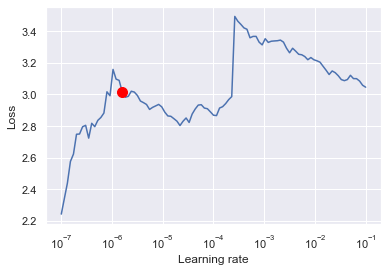

In [23]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-7,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# Callbacks ,Trainer and final Model¶

In [24]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-7, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs") 

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=5e-7,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1, 
    loss=pytorch_forecasting.metrics.RMSE(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 20.7k


# Fit the model

In [25]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 144   
4  | static_variable_selection          | VariableSelectionNetwork        | 4.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check:   0%|                            | 0/2 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Global seed set to 42


Epoch 0:   0%|                                           | 0/85 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 0:  12%| | 10/85 [00:01<00:12,  5.82it/s, loss=2.73, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 0:  24%|▏| 20/85 [00:03<00:10,  6.34it/s, loss=2.93, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 0:  35%|▎| 30/85 [00:04<00:08,  6.70it/s, loss=2.91, v_num=4, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 0:  38%|▍| 32/85 [00:06<00:09,  5.32it/s, loss=2.91, v_num=4, train_loss_s
Validating:   4%|█▏                              | 2/55 [00:02<00:53,  1.00s/it]
Epoch 0:  40%|▍| 34/85 [00:07<00:10,  4.68it/s, loss=2.91, v_num=4, train_loss_s
Validating:   7%|██▎                             | 4/55 [00:03<00:38,  1.34it/s]
Epoch 0:  42%|▍| 36/85 [00:08<00:11,  4.17it/s, loss=2.91, v_num=4, train_loss_s
Validating:  11%|███▍                            | 6/55 [00:04<00:34,  1.44it/s]
Epoch 0:  45%|▍| 38/85 [00:09<00:12,  3.86it/s, loss=2.91, v_num=4, train_loss_s
Validating:  15%|████▋                           | 8/55 [00:05<00:30,  1.54it/s]
Epoch 0:  47%|▍| 40/85 [00:11<00:12,  3.61it/s, loss=2.91, v_num=4, train_loss_s
Validating:  18%|█████▋                         | 10/55 [00:07<00:28,  1.58it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 0:  49%|▍| 42/85 [00:12<00:12,  3.37it/s, loss=2.91, v_num=4, train_loss_s
Validating:  22%|██████▊                        | 12/55 [00:08<00:30,  1.43it/s]
Epoch 0:  52%|▌| 44/85 [00:13<00:12,  3.19it/s, loss=2.91, v_num=4, train_loss_s
Validating:  25%|███████▉                       | 14/55 [00:09<00:26,  1.52it/s]
Epoch 0:  54%|▌| 46/85 [00:15<00:12,  3.05it/s, loss=2.91, v_num=4, train_loss_s
Validating:  29%|█████████                      | 16/55 [00:11<00:25,  1.56it/s]
Epoch 0:  56%|▌| 48/85 [00:16<00:12,  2.91it/s, loss=2.91, v_num=4, train_loss_s
Validating:  33%|██████████▏                    | 18/55 [00:12<00:24,  1.50it/s]
Epoch 0:  59%|▌| 50/85 [00:17<00:12,  2.82it/s, loss=2.91, v_num=4, train_loss_s
Validating:  36%|███████████▎                   | 20/55 [00:13<00:22,  1.55it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 0:  61%|▌| 52/85 [00:19<00:12,  2.71it/s, loss=2.91, v_num=4, train_loss_s
Validating:  40%|████████████▍                  | 22/55 [00:15<00:22,  1.48it/s]
Epoch 0:  64%|▋| 54/85 [00:20<00:11,  2.63it/s, loss=2.91, v_num=4, train_loss_s
Validating:  44%|█████████████▌                 | 24/55 [00:16<00:21,  1.46it/s]
Epoch 0:  66%|▋| 56/85 [00:21<00:11,  2.56it/s, loss=2.91, v_num=4, train_loss_s
Validating:  47%|██████████████▋                | 26/55 [00:18<00:19,  1.49it/s]
Epoch 0:  68%|▋| 58/85 [00:23<00:10,  2.50it/s, loss=2.91, v_num=4, train_loss_s
Validating:  51%|███████████████▊               | 28/55 [00:19<00:17,  1.54it/s]
Epoch 0:  71%|▋| 60/85 [00:24<00:10,  2.44it/s, loss=2.91, v_num=4, train_loss_s
Validating:  55%|████████████████▉              | 30/55 [00:20<00:16,  1.48it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 0:  73%|▋| 62/85 [00:26<00:09,  2.38it/s, loss=2.91, v_num=4, train_loss_s
Validating:  58%|██████████████████             | 32/55 [00:22<00:16,  1.39it/s]
Epoch 0:  75%|▊| 64/85 [00:27<00:08,  2.34it/s, loss=2.91, v_num=4, train_loss_s
Validating:  62%|███████████████████▏           | 34/55 [00:23<00:15,  1.34it/s]
Epoch 0:  78%|▊| 66/85 [00:28<00:08,  2.28it/s, loss=2.91, v_num=4, train_loss_s
Validating:  65%|████████████████████▎          | 36/55 [00:25<00:13,  1.43it/s]
Epoch 0:  80%|▊| 68/85 [00:30<00:07,  2.25it/s, loss=2.91, v_num=4, train_loss_s
Validating:  69%|█████████████████████▍         | 38/55 [00:26<00:11,  1.47it/s]
Epoch 0:  82%|▊| 70/85 [00:31<00:06,  2.21it/s, loss=2.91, v_num=4, train_loss_s
Validating:  73%|██████████████████████▌        | 40/55 [00:27<00:09,  1.51it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 0:  85%|▊| 72/85 [00:33<00:05,  2.17it/s, loss=2.91, v_num=4, train_loss_s
Validating:  76%|███████████████████████▋       | 42/55 [00:29<00:09,  1.38it/s]
Epoch 0:  87%|▊| 74/85 [00:34<00:05,  2.15it/s, loss=2.91, v_num=4, train_loss_s
Validating:  80%|████████████████████████▊      | 44/55 [00:30<00:07,  1.44it/s]
Epoch 0:  89%|▉| 76/85 [00:35<00:04,  2.12it/s, loss=2.91, v_num=4, train_loss_s
Validating:  84%|█████████████████████████▉     | 46/55 [00:32<00:06,  1.46it/s]
Epoch 0:  92%|▉| 78/85 [00:37<00:03,  2.09it/s, loss=2.91, v_num=4, train_loss_s
Validating:  87%|███████████████████████████    | 48/55 [00:33<00:04,  1.44it/s]
Epoch 0:  94%|▉| 80/85 [00:38<00:02,  2.07it/s, loss=2.91, v_num=4, train_loss_s
Validating:  91%|████████████████████████████▏  | 50/55 [00:34<00:03,  1.48it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 0:  96%|▉| 82/85 [00:40<00:01,  2.04it/s, loss=2.91, v_num=4, train_loss_s
Validating:  95%|█████████████████████████████▎ | 52/55 [00:36<00:02,  1.36it/s]
Epoch 0:  99%|▉| 84/85 [00:41<00:00,  2.02it/s, loss=2.91, v_num=4, train_loss_s
Validating:  98%|██████████████████████████████▍| 54/55 [00:37<00:00,  1.40it/s]
Epoch 0: 100%|█| 85/85 [00:42<00:00,  1.99it/s, loss=2.91, v_num=4, train_loss_s
Epoch 1:   0%| | 0/85 [00:00<?, ?it/s, loss=2.91, v_num=4, train_loss_step=3.050

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 1:  12%| | 10/85 [00:01<00:13,  5.40it/s, loss=2.74, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 1:  24%|▏| 20/85 [00:03<00:10,  6.18it/s, loss=2.73, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 1:  35%|▎| 30/85 [00:04<00:08,  6.47it/s, loss=2.75, v_num=4, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 1:  38%|▍| 32/85 [00:06<00:10,  5.17it/s, loss=2.75, v_num=4, train_loss_s
Validating:   4%|█▏                              | 2/55 [00:02<00:53,  1.01s/it]
Epoch 1:  40%|▍| 34/85 [00:07<00:11,  4.54it/s, loss=2.75, v_num=4, train_loss_s
Validating:   7%|██▎                             | 4/55 [00:03<00:39,  1.28it/s]
Epoch 1:  42%|▍| 36/85 [00:08<00:11,  4.09it/s, loss=2.75, v_num=4, train_loss_s
Validating:  11%|███▍                            | 6/55 [00:04<00:34,  1.43it/s]
Epoch 1:  45%|▍| 38/85 [00:10<00:12,  3.77it/s, loss=2.75, v_num=4, train_loss_s
Validating:  15%|████▋                           | 8/55 [00:06<00:34,  1.36it/s]
Epoch 1:  47%|▍| 40/85 [00:11<00:13,  3.45it/s, loss=2.75, v_num=4, train_loss_s
Validating:  18%|█████▋                         | 10/55 [00:07<00:31,  1.43it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 1:  49%|▍| 42/85 [00:13<00:13,  3.21it/s, loss=2.75, v_num=4, train_loss_s
Validating:  22%|██████▊                        | 12/55 [00:09<00:30,  1.42it/s]
Epoch 1:  52%|▌| 44/85 [00:14<00:13,  3.06it/s, loss=2.75, v_num=4, train_loss_s
Validating:  25%|███████▉                       | 14/55 [00:10<00:29,  1.37it/s]
Epoch 1:  54%|▌| 46/85 [00:15<00:13,  2.90it/s, loss=2.75, v_num=4, train_loss_s
Validating:  29%|█████████                      | 16/55 [00:11<00:27,  1.44it/s]
Epoch 1:  56%|▌| 48/85 [00:17<00:13,  2.80it/s, loss=2.75, v_num=4, train_loss_s
Validating:  33%|██████████▏                    | 18/55 [00:13<00:24,  1.48it/s]
Epoch 1:  59%|▌| 50/85 [00:18<00:12,  2.70it/s, loss=2.75, v_num=4, train_loss_s
Validating:  36%|███████████▎                   | 20/55 [00:14<00:23,  1.47it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 1:  61%|▌| 52/85 [00:20<00:12,  2.59it/s, loss=2.75, v_num=4, train_loss_s
Validating:  40%|████████████▍                  | 22/55 [00:16<00:27,  1.21it/s]
Epoch 1:  64%|▋| 54/85 [00:22<00:12,  2.45it/s, loss=2.75, v_num=4, train_loss_s
Validating:  44%|█████████████▌                 | 24/55 [00:18<00:27,  1.14it/s]
Epoch 1:  66%|▋| 56/85 [00:23<00:12,  2.37it/s, loss=2.75, v_num=4, train_loss_s
Validating:  47%|██████████████▋                | 26/55 [00:19<00:23,  1.21it/s]
Epoch 1:  68%|▋| 58/85 [00:25<00:11,  2.30it/s, loss=2.75, v_num=4, train_loss_s
Validating:  51%|███████████████▊               | 28/55 [00:21<00:21,  1.25it/s]
Epoch 1:  71%|▋| 60/85 [00:27<00:11,  2.21it/s, loss=2.75, v_num=4, train_loss_s
Validating:  55%|████████████████▉              | 30/55 [00:23<00:22,  1.12it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 1:  73%|▋| 62/85 [00:29<00:10,  2.11it/s, loss=2.75, v_num=4, train_loss_s
Validating:  58%|██████████████████             | 32/55 [00:25<00:23,  1.04s/it]
Epoch 1:  75%|▊| 64/85 [00:31<00:10,  2.05it/s, loss=2.75, v_num=4, train_loss_s
Validating:  62%|███████████████████▏           | 34/55 [00:27<00:19,  1.08it/s]
Epoch 1:  78%|▊| 66/85 [00:32<00:09,  2.01it/s, loss=2.75, v_num=4, train_loss_s
Validating:  65%|████████████████████▎          | 36/55 [00:29<00:19,  1.00s/it]
Epoch 1:  80%|▊| 68/85 [00:34<00:08,  1.94it/s, loss=2.75, v_num=4, train_loss_s
Validating:  69%|█████████████████████▍         | 38/55 [00:31<00:15,  1.12it/s]
Epoch 1:  82%|▊| 70/85 [00:36<00:07,  1.91it/s, loss=2.75, v_num=4, train_loss_s
Validating:  73%|██████████████████████▌        | 40/55 [00:32<00:13,  1.15it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 1:  85%|▊| 72/85 [00:38<00:06,  1.87it/s, loss=2.75, v_num=4, train_loss_s
Validating:  76%|███████████████████████▋       | 42/55 [00:34<00:11,  1.09it/s]
Epoch 1:  87%|▊| 74/85 [00:40<00:05,  1.84it/s, loss=2.75, v_num=4, train_loss_s
Validating:  80%|████████████████████████▊      | 44/55 [00:36<00:09,  1.12it/s]
Epoch 1:  89%|▉| 76/85 [00:41<00:04,  1.82it/s, loss=2.75, v_num=4, train_loss_s
Validating:  84%|█████████████████████████▉     | 46/55 [00:38<00:07,  1.20it/s]
Epoch 1:  92%|▉| 78/85 [00:43<00:03,  1.79it/s, loss=2.75, v_num=4, train_loss_s
Validating:  87%|███████████████████████████    | 48/55 [00:39<00:05,  1.22it/s]
Epoch 1:  94%|▉| 80/85 [00:45<00:02,  1.77it/s, loss=2.75, v_num=4, train_loss_s
Validating:  91%|████████████████████████████▏  | 50/55 [00:41<00:04,  1.15it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 1:  96%|▉| 82/85 [00:47<00:01,  1.74it/s, loss=2.75, v_num=4, train_loss_s
Validating:  95%|█████████████████████████████▎ | 52/55 [00:43<00:02,  1.15it/s]
Epoch 1:  99%|▉| 84/85 [00:48<00:00,  1.72it/s, loss=2.75, v_num=4, train_loss_s
Validating:  98%|██████████████████████████████▍| 54/55 [00:44<00:00,  1.23it/s]
Epoch 1: 100%|█| 85/85 [00:49<00:00,  1.70it/s, loss=2.75, v_num=4, train_loss_s
Epoch 2:   0%| | 0/85 [00:00<?, ?it/s, loss=2.75, v_num=4, train_loss_step=3.310

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 2:  12%| | 10/85 [00:02<00:16,  4.60it/s, loss=2.82, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 2:  24%|▏| 20/85 [00:03<00:12,  5.30it/s, loss=3.39, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 2:  35%|▎| 30/85 [00:05<00:09,  5.71it/s, loss=3.3, v_num=4, train_loss_st
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 2:  38%|▍| 32/85 [00:07<00:12,  4.37it/s, loss=3.3, v_num=4, train_loss_st
Validating:   4%|█▏                              | 2/55 [00:02<01:12,  1.36s/it]
Epoch 2:  40%|▍| 34/85 [00:09<00:13,  3.71it/s, loss=3.3, v_num=4, train_loss_st
Validating:   7%|██▎                             | 4/55 [00:04<00:55,  1.08s/it]
Epoch 2:  42%|▍| 36/85 [00:11<00:15,  3.26it/s, loss=3.3, v_num=4, train_loss_st
Validating:  11%|███▍                            | 6/55 [00:06<00:50,  1.04s/it]
Epoch 2:  45%|▍| 38/85 [00:12<00:15,  2.94it/s, loss=3.3, v_num=4, train_loss_st
Validating:  15%|████▋                           | 8/55 [00:08<00:41,  1.14it/s]
Epoch 2:  47%|▍| 40/85 [00:14<00:16,  2.78it/s, loss=3.3, v_num=4, train_loss_st
Validating:  18%|█████▋                         | 10/55 [00:10<00:39,  1.15it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 2:  49%|▍| 42/85 [00:16<00:16,  2.57it/s, loss=3.3, v_num=4, train_loss_st
Validating:  22%|██████▊                        | 12/55 [00:11<00:36,  1.18it/s]
Epoch 2:  52%|▌| 44/85 [00:17<00:16,  2.46it/s, loss=3.3, v_num=4, train_loss_st
Validating:  25%|███████▉                       | 14/55 [00:13<00:37,  1.11it/s]
Epoch 2:  54%|▌| 46/85 [00:20<00:17,  2.29it/s, loss=3.3, v_num=4, train_loss_st
Validating:  29%|█████████                      | 16/55 [00:15<00:34,  1.13it/s]
Epoch 2:  56%|▌| 48/85 [00:21<00:16,  2.24it/s, loss=3.3, v_num=4, train_loss_st
Validating:  33%|██████████▏                    | 18/55 [00:16<00:28,  1.29it/s]
Epoch 2:  59%|▌| 50/85 [00:22<00:15,  2.20it/s, loss=3.3, v_num=4, train_loss_st
Validating:  36%|███████████▎                   | 20/55 [00:18<00:25,  1.38it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 2:  61%|▌| 52/85 [00:24<00:15,  2.14it/s, loss=3.3, v_num=4, train_loss_st
Validating:  40%|████████████▍                  | 22/55 [00:19<00:24,  1.34it/s]
Epoch 2:  64%|▋| 54/85 [00:25<00:14,  2.08it/s, loss=3.3, v_num=4, train_loss_st
Validating:  44%|█████████████▌                 | 24/55 [00:21<00:26,  1.17it/s]
Epoch 2:  66%|▋| 56/85 [00:27<00:14,  2.01it/s, loss=3.3, v_num=4, train_loss_st
Validating:  47%|██████████████▋                | 26/55 [00:23<00:25,  1.15it/s]
Epoch 2:  68%|▋| 58/85 [00:29<00:13,  1.98it/s, loss=3.3, v_num=4, train_loss_st
Validating:  51%|███████████████▊               | 28/55 [00:24<00:20,  1.29it/s]
Epoch 2:  71%|▋| 60/85 [00:30<00:12,  1.95it/s, loss=3.3, v_num=4, train_loss_st
Validating:  55%|████████████████▉              | 30/55 [00:26<00:19,  1.31it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 2:  73%|▋| 62/85 [00:32<00:12,  1.89it/s, loss=3.3, v_num=4, train_loss_st
Validating:  58%|██████████████████             | 32/55 [00:28<00:20,  1.13it/s]
Epoch 2:  75%|▊| 64/85 [00:34<00:11,  1.86it/s, loss=3.3, v_num=4, train_loss_st
Validating:  62%|███████████████████▏           | 34/55 [00:30<00:18,  1.14it/s]
Epoch 2:  78%|▊| 66/85 [00:36<00:10,  1.82it/s, loss=3.3, v_num=4, train_loss_st
Validating:  65%|████████████████████▎          | 36/55 [00:31<00:15,  1.21it/s]
Epoch 2:  80%|▊| 68/85 [00:37<00:09,  1.81it/s, loss=3.3, v_num=4, train_loss_st
Validating:  69%|█████████████████████▍         | 38/55 [00:33<00:12,  1.33it/s]
Epoch 2:  82%|▊| 70/85 [00:39<00:08,  1.79it/s, loss=3.3, v_num=4, train_loss_st
Validating:  73%|██████████████████████▌        | 40/55 [00:34<00:11,  1.36it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 2:  85%|▊| 72/85 [00:40<00:07,  1.77it/s, loss=3.3, v_num=4, train_loss_st
Validating:  76%|███████████████████████▋       | 42/55 [00:36<00:09,  1.32it/s]
Epoch 2:  87%|▊| 74/85 [00:42<00:06,  1.76it/s, loss=3.3, v_num=4, train_loss_st
Validating:  80%|████████████████████████▊      | 44/55 [00:37<00:08,  1.37it/s]
Epoch 2:  89%|▉| 76/85 [00:43<00:05,  1.75it/s, loss=3.3, v_num=4, train_loss_st
Validating:  84%|█████████████████████████▉     | 46/55 [00:38<00:06,  1.36it/s]
Epoch 2:  92%|▉| 78/85 [00:44<00:04,  1.74it/s, loss=3.3, v_num=4, train_loss_st
Validating:  87%|███████████████████████████    | 48/55 [00:40<00:05,  1.26it/s]
Epoch 2:  94%|▉| 80/85 [00:46<00:02,  1.71it/s, loss=3.3, v_num=4, train_loss_st
Validating:  91%|████████████████████████████▏  | 50/55 [00:42<00:04,  1.25it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 2:  96%|▉| 82/85 [00:48<00:01,  1.69it/s, loss=3.3, v_num=4, train_loss_st
Validating:  95%|█████████████████████████████▎ | 52/55 [00:44<00:02,  1.19it/s]
Epoch 2:  99%|▉| 84/85 [00:50<00:00,  1.66it/s, loss=3.3, v_num=4, train_loss_st
Validating:  98%|██████████████████████████████▍| 54/55 [00:46<00:00,  1.08it/s]
Epoch 2: 100%|█| 85/85 [00:52<00:00,  1.63it/s, loss=3.3, v_num=4, train_loss_st
Epoch 3:   0%| | 0/85 [00:00<?, ?it/s, loss=3.3, v_num=4, train_loss_step=3.460,

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 3:  12%| | 10/85 [00:02<00:16,  4.66it/s, loss=2.79, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 3:  24%|▏| 20/85 [00:03<00:11,  5.51it/s, loss=2.86, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 3:  35%|▎| 30/85 [00:05<00:09,  5.83it/s, loss=2.79, v_num=4, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 3:  38%|▍| 32/85 [00:06<00:11,  4.69it/s, loss=2.79, v_num=4, train_loss_s
Validating:   4%|█▏                              | 2/55 [00:02<01:00,  1.14s/it]
Epoch 3:  40%|▍| 34/85 [00:08<00:12,  4.10it/s, loss=2.79, v_num=4, train_loss_s
Validating:   7%|██▎                             | 4/55 [00:03<00:43,  1.18it/s]
Epoch 3:  42%|▍| 36/85 [00:09<00:13,  3.71it/s, loss=2.79, v_num=4, train_loss_s
Validating:  11%|███▍                            | 6/55 [00:05<00:37,  1.29it/s]
Epoch 3:  45%|▍| 38/85 [00:11<00:14,  3.34it/s, loss=2.79, v_num=4, train_loss_s
Validating:  15%|████▋                           | 8/55 [00:06<00:36,  1.27it/s]
Epoch 3:  47%|▍| 40/85 [00:12<00:14,  3.13it/s, loss=2.79, v_num=4, train_loss_s
Validating:  18%|█████▋                         | 10/55 [00:08<00:33,  1.35it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 3:  49%|▍| 42/85 [00:14<00:14,  2.94it/s, loss=2.79, v_num=4, train_loss_s
Validating:  22%|██████▊                        | 12/55 [00:09<00:31,  1.35it/s]
Epoch 3:  52%|▌| 44/85 [00:15<00:14,  2.79it/s, loss=2.79, v_num=4, train_loss_s
Validating:  25%|███████▉                       | 14/55 [00:11<00:30,  1.33it/s]
Epoch 3:  54%|▌| 46/85 [00:17<00:14,  2.63it/s, loss=2.79, v_num=4, train_loss_s
Validating:  29%|█████████                      | 16/55 [00:13<00:35,  1.09it/s]
Epoch 3:  56%|▌| 48/85 [00:19<00:15,  2.47it/s, loss=2.79, v_num=4, train_loss_s
Validating:  33%|██████████▏                    | 18/55 [00:14<00:30,  1.20it/s]
Epoch 3:  59%|▌| 50/85 [00:20<00:14,  2.38it/s, loss=2.79, v_num=4, train_loss_s
Validating:  36%|███████████▎                   | 20/55 [00:16<00:27,  1.26it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 3:  61%|▌| 52/85 [00:22<00:14,  2.31it/s, loss=2.79, v_num=4, train_loss_s
Validating:  40%|████████████▍                  | 22/55 [00:18<00:27,  1.18it/s]
Epoch 3:  64%|▋| 54/85 [00:24<00:13,  2.23it/s, loss=2.79, v_num=4, train_loss_s
Validating:  44%|█████████████▌                 | 24/55 [00:20<00:26,  1.16it/s]
Epoch 3:  66%|▋| 56/85 [00:25<00:13,  2.17it/s, loss=2.79, v_num=4, train_loss_s
Validating:  47%|██████████████▋                | 26/55 [00:21<00:25,  1.14it/s]
Epoch 3:  68%|▋| 58/85 [00:27<00:12,  2.09it/s, loss=2.79, v_num=4, train_loss_s
Validating:  51%|███████████████▊               | 28/55 [00:23<00:21,  1.25it/s]
Epoch 3:  71%|▋| 60/85 [00:29<00:12,  2.06it/s, loss=2.79, v_num=4, train_loss_s
Validating:  55%|████████████████▉              | 30/55 [00:24<00:18,  1.34it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 3:  73%|▋| 62/85 [00:30<00:11,  2.02it/s, loss=2.79, v_num=4, train_loss_s
Validating:  58%|██████████████████             | 32/55 [00:26<00:17,  1.30it/s]
Epoch 3:  75%|▊| 64/85 [00:32<00:10,  1.99it/s, loss=2.79, v_num=4, train_loss_s
Validating:  62%|███████████████████▏           | 34/55 [00:27<00:15,  1.34it/s]
Epoch 3:  78%|▊| 66/85 [00:33<00:09,  1.96it/s, loss=2.79, v_num=4, train_loss_s
Validating:  65%|████████████████████▎          | 36/55 [00:29<00:15,  1.19it/s]
Epoch 3:  80%|▊| 68/85 [00:35<00:08,  1.92it/s, loss=2.79, v_num=4, train_loss_s
Validating:  69%|█████████████████████▍         | 38/55 [00:31<00:13,  1.28it/s]
Epoch 3:  82%|▊| 70/85 [00:37<00:07,  1.89it/s, loss=2.79, v_num=4, train_loss_s
Validating:  73%|██████████████████████▌        | 40/55 [00:32<00:11,  1.28it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 3:  85%|▊| 72/85 [00:38<00:06,  1.86it/s, loss=2.79, v_num=4, train_loss_s
Validating:  76%|███████████████████████▋       | 42/55 [00:34<00:10,  1.27it/s]
Epoch 3:  87%|▊| 74/85 [00:40<00:05,  1.84it/s, loss=2.79, v_num=4, train_loss_s
Validating:  80%|████████████████████████▊      | 44/55 [00:36<00:09,  1.16it/s]
Epoch 3:  89%|▉| 76/85 [00:41<00:04,  1.81it/s, loss=2.79, v_num=4, train_loss_s
Validating:  84%|█████████████████████████▉     | 46/55 [00:37<00:07,  1.15it/s]
Epoch 3:  92%|▉| 78/85 [00:43<00:03,  1.79it/s, loss=2.79, v_num=4, train_loss_s
Validating:  87%|███████████████████████████    | 48/55 [00:39<00:05,  1.31it/s]
Epoch 3:  94%|▉| 80/85 [00:44<00:02,  1.78it/s, loss=2.79, v_num=4, train_loss_s
Validating:  91%|████████████████████████████▏  | 50/55 [00:40<00:03,  1.40it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 3:  96%|▉| 82/85 [00:46<00:01,  1.77it/s, loss=2.79, v_num=4, train_loss_s
Validating:  95%|█████████████████████████████▎ | 52/55 [00:41<00:02,  1.35it/s]
Epoch 3:  99%|▉| 84/85 [00:47<00:00,  1.76it/s, loss=2.79, v_num=4, train_loss_s
Validating:  98%|██████████████████████████████▍| 54/55 [00:43<00:00,  1.46it/s]
Epoch 3: 100%|█| 85/85 [00:48<00:00,  1.74it/s, loss=2.79, v_num=4, train_loss_s
Epoch 4:   0%| | 0/85 [00:00<?, ?it/s, loss=2.79, v_num=4, train_loss_step=2.500

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Epoch 4:  12%| | 10/85 [00:01<00:14,  5.17it/s, loss=3.46, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 4:  24%|▏| 20/85 [00:03<00:11,  5.89it/s, loss=3.4, v_num=4, train_loss_st

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 4:  35%|▎| 30/85 [00:04<00:08,  6.14it/s, loss=2.81, v_num=4, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 4:  38%|▍| 32/85 [00:06<00:10,  4.99it/s, loss=2.81, v_num=4, train_loss_s
Validating:   4%|█▏                              | 2/55 [00:02<00:54,  1.03s/it]
Epoch 4:  40%|▍| 34/85 [00:07<00:11,  4.33it/s, loss=2.81, v_num=4, train_loss_s
Validating:   7%|██▎                             | 4/55 [00:03<00:41,  1.22it/s]
Epoch 4:  42%|▍| 36/85 [00:09<00:12,  3.88it/s, loss=2.81, v_num=4, train_loss_s
Validating:  11%|███▍                            | 6/55 [00:05<00:37,  1.32it/s]
Epoch 4:  45%|▍| 38/85 [00:10<00:13,  3.46it/s, loss=2.81, v_num=4, train_loss_s
Validating:  15%|████▋                           | 8/55 [00:06<00:38,  1.22it/s]
Epoch 4:  47%|▍| 40/85 [00:12<00:14,  3.20it/s, loss=2.81, v_num=4, train_loss_s
Validating:  18%|█████▋                         | 10/55 [00:08<00:33,  1.33it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 4:  49%|▍| 42/85 [00:13<00:14,  3.01it/s, loss=2.81, v_num=4, train_loss_s
Validating:  22%|██████▊                        | 12/55 [00:09<00:30,  1.39it/s]
Epoch 4:  52%|▌| 44/85 [00:15<00:14,  2.89it/s, loss=2.81, v_num=4, train_loss_s
Validating:  25%|███████▉                       | 14/55 [00:11<00:29,  1.40it/s]
Epoch 4:  54%|▌| 46/85 [00:16<00:14,  2.76it/s, loss=2.81, v_num=4, train_loss_s
Validating:  29%|█████████                      | 16/55 [00:12<00:27,  1.43it/s]
Epoch 4:  56%|▌| 48/85 [00:18<00:13,  2.66it/s, loss=2.81, v_num=4, train_loss_s
Validating:  33%|██████████▏                    | 18/55 [00:14<00:28,  1.30it/s]
Epoch 4:  59%|▌| 50/85 [00:19<00:13,  2.54it/s, loss=2.81, v_num=4, train_loss_s
Validating:  36%|███████████▎                   | 20/55 [00:15<00:24,  1.40it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 4:  61%|▌| 52/85 [00:21<00:13,  2.46it/s, loss=2.81, v_num=4, train_loss_s
Validating:  40%|████████████▍                  | 22/55 [00:16<00:23,  1.38it/s]
Epoch 4:  64%|▋| 54/85 [00:22<00:12,  2.40it/s, loss=2.81, v_num=4, train_loss_s
Validating:  44%|█████████████▌                 | 24/55 [00:18<00:22,  1.38it/s]
Epoch 4:  66%|▋| 56/85 [00:23<00:12,  2.34it/s, loss=2.81, v_num=4, train_loss_s
Validating:  47%|██████████████▋                | 26/55 [00:19<00:20,  1.41it/s]
Epoch 4:  68%|▋| 58/85 [00:25<00:11,  2.30it/s, loss=2.81, v_num=4, train_loss_s
Validating:  51%|███████████████▊               | 28/55 [00:21<00:18,  1.47it/s]
Epoch 4:  71%|▋| 60/85 [00:26<00:11,  2.24it/s, loss=2.81, v_num=4, train_loss_s
Validating:  55%|████████████████▉              | 30/55 [00:22<00:17,  1.39it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 4:  73%|▋| 62/85 [00:28<00:10,  2.19it/s, loss=2.81, v_num=4, train_loss_s
Validating:  58%|██████████████████             | 32/55 [00:24<00:16,  1.40it/s]
Epoch 4:  75%|▊| 64/85 [00:29<00:09,  2.16it/s, loss=2.81, v_num=4, train_loss_s
Validating:  62%|███████████████████▏           | 34/55 [00:25<00:14,  1.45it/s]
Epoch 4:  78%|▊| 66/85 [00:30<00:08,  2.14it/s, loss=2.81, v_num=4, train_loss_s
Validating:  65%|████████████████████▎          | 36/55 [00:26<00:12,  1.48it/s]
Epoch 4:  80%|▊| 68/85 [00:32<00:08,  2.11it/s, loss=2.81, v_num=4, train_loss_s
Validating:  69%|█████████████████████▍         | 38/55 [00:28<00:11,  1.48it/s]
Epoch 4:  82%|▊| 70/85 [00:33<00:07,  2.07it/s, loss=2.81, v_num=4, train_loss_s
Validating:  73%|██████████████████████▌        | 40/55 [00:29<00:10,  1.44it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 4:  85%|▊| 72/85 [00:35<00:06,  2.04it/s, loss=2.81, v_num=4, train_loss_s
Validating:  76%|███████████████████████▋       | 42/55 [00:30<00:09,  1.40it/s]
Epoch 4:  87%|▊| 74/85 [00:36<00:05,  2.02it/s, loss=2.81, v_num=4, train_loss_s
Validating:  80%|████████████████████████▊      | 44/55 [00:32<00:07,  1.46it/s]
Epoch 4:  89%|▉| 76/85 [00:37<00:04,  2.01it/s, loss=2.81, v_num=4, train_loss_s
Validating:  84%|█████████████████████████▉     | 46/55 [00:33<00:06,  1.50it/s]
Epoch 4:  92%|▉| 78/85 [00:39<00:03,  1.99it/s, loss=2.81, v_num=4, train_loss_s
Validating:  87%|███████████████████████████    | 48/55 [00:34<00:04,  1.54it/s]
Epoch 4:  94%|▉| 80/85 [00:40<00:02,  1.98it/s, loss=2.81, v_num=4, train_loss_s
Validating:  91%|████████████████████████████▏  | 50/55 [00:36<00:03,  1.38it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 4:  96%|▉| 82/85 [00:42<00:01,  1.95it/s, loss=2.81, v_num=4, train_loss_s
Validating:  95%|█████████████████████████████▎ | 52/55 [00:37<00:02,  1.39it/s]
Epoch 4:  99%|▉| 84/85 [00:43<00:00,  1.94it/s, loss=2.81, v_num=4, train_loss_s
Epoch 4: 100%|█| 85/85 [00:44<00:00,  1.92it/s, loss=2.81, v_num=4, train_loss_s
Epoch 5:   0%| | 0/85 [00:00<?, ?it/s, loss=2.81, v_num=4, train_loss_step=2.270

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 5:  12%| | 10/85 [00:01<00:13,  5.47it/s, loss=2.84, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 5:  24%|▏| 20/85 [00:03<00:10,  6.16it/s, loss=2.88, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 5:  35%|▎| 30/85 [00:04<00:08,  6.52it/s, loss=2.93, v_num=4, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 5:  38%|▍| 32/85 [00:06<00:09,  5.31it/s, loss=2.93, v_num=4, train_loss_s
Validating:   4%|█▏                              | 2/55 [00:02<01:00,  1.15s/it]
Epoch 5:  40%|▍| 34/85 [00:07<00:11,  4.45it/s, loss=2.93, v_num=4, train_loss_s
Validating:   7%|██▎                             | 4/55 [00:03<00:41,  1.23it/s]
Epoch 5:  42%|▍| 36/85 [00:08<00:12,  4.03it/s, loss=2.93, v_num=4, train_loss_s
Validating:  11%|███▍                            | 6/55 [00:04<00:35,  1.39it/s]
Epoch 5:  45%|▍| 38/85 [00:10<00:12,  3.73it/s, loss=2.93, v_num=4, train_loss_s
Validating:  15%|████▋                           | 8/55 [00:06<00:31,  1.50it/s]
Epoch 5:  47%|▍| 40/85 [00:11<00:12,  3.49it/s, loss=2.93, v_num=4, train_loss_s
Validating:  18%|█████▋                         | 10/55 [00:07<00:29,  1.51it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 5:  49%|▍| 42/85 [00:12<00:13,  3.24it/s, loss=2.93, v_num=4, train_loss_s
Validating:  22%|██████▊                        | 12/55 [00:08<00:29,  1.46it/s]
Epoch 5:  52%|▌| 44/85 [00:14<00:13,  3.10it/s, loss=2.93, v_num=4, train_loss_s
Validating:  25%|███████▉                       | 14/55 [00:10<00:30,  1.35it/s]
Epoch 5:  54%|▌| 46/85 [00:15<00:13,  2.92it/s, loss=2.93, v_num=4, train_loss_s
Validating:  29%|█████████                      | 16/55 [00:11<00:27,  1.44it/s]
Epoch 5:  56%|▌| 48/85 [00:17<00:13,  2.81it/s, loss=2.93, v_num=4, train_loss_s
Validating:  33%|██████████▏                    | 18/55 [00:13<00:26,  1.40it/s]
Epoch 5:  59%|▌| 50/85 [00:18<00:13,  2.69it/s, loss=2.93, v_num=4, train_loss_s
Validating:  36%|███████████▎                   | 20/55 [00:14<00:24,  1.44it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 5:  61%|▌| 52/85 [00:20<00:12,  2.59it/s, loss=2.93, v_num=4, train_loss_s
Validating:  40%|████████████▍                  | 22/55 [00:16<00:23,  1.39it/s]
Epoch 5:  64%|▋| 54/85 [00:21<00:12,  2.52it/s, loss=2.93, v_num=4, train_loss_s
Validating:  44%|█████████████▌                 | 24/55 [00:17<00:21,  1.43it/s]
Epoch 5:  66%|▋| 56/85 [00:22<00:11,  2.46it/s, loss=2.93, v_num=4, train_loss_s
Validating:  47%|██████████████▋                | 26/55 [00:19<00:22,  1.30it/s]
Epoch 5:  68%|▋| 58/85 [00:24<00:11,  2.38it/s, loss=2.93, v_num=4, train_loss_s
Validating:  51%|███████████████▊               | 28/55 [00:20<00:19,  1.41it/s]
Epoch 5:  71%|▋| 60/85 [00:25<00:10,  2.34it/s, loss=2.93, v_num=4, train_loss_s
Validating:  55%|████████████████▉              | 30/55 [00:21<00:16,  1.49it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 5:  73%|▋| 62/85 [00:27<00:10,  2.29it/s, loss=2.93, v_num=4, train_loss_s
Validating:  58%|██████████████████             | 32/55 [00:23<00:16,  1.43it/s]
Epoch 5:  75%|▊| 64/85 [00:28<00:09,  2.25it/s, loss=2.93, v_num=4, train_loss_s
Validating:  62%|███████████████████▏           | 34/55 [00:24<00:14,  1.47it/s]
Epoch 5:  78%|▊| 66/85 [00:29<00:08,  2.22it/s, loss=2.93, v_num=4, train_loss_s
Validating:  65%|████████████████████▎          | 36/55 [00:25<00:12,  1.51it/s]
Epoch 5:  80%|▊| 68/85 [00:31<00:07,  2.19it/s, loss=2.93, v_num=4, train_loss_s
Validating:  69%|█████████████████████▍         | 38/55 [00:27<00:12,  1.36it/s]
Epoch 5:  82%|▊| 70/85 [00:32<00:06,  2.15it/s, loss=2.93, v_num=4, train_loss_s
Validating:  73%|██████████████████████▌        | 40/55 [00:28<00:10,  1.49it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 5:  85%|▊| 72/85 [00:33<00:06,  2.12it/s, loss=2.93, v_num=4, train_loss_s
Validating:  76%|███████████████████████▋       | 42/55 [00:29<00:08,  1.47it/s]
Epoch 5:  87%|▊| 74/85 [00:35<00:05,  2.10it/s, loss=2.93, v_num=4, train_loss_s
Validating:  80%|████████████████████████▊      | 44/55 [00:31<00:07,  1.49it/s]
Epoch 5:  89%|▉| 76/85 [00:36<00:04,  2.08it/s, loss=2.93, v_num=4, train_loss_s
Validating:  84%|█████████████████████████▉     | 46/55 [00:32<00:05,  1.51it/s]
Epoch 5:  92%|▉| 78/85 [00:37<00:03,  2.06it/s, loss=2.93, v_num=4, train_loss_s
Validating:  87%|███████████████████████████    | 48/55 [00:33<00:04,  1.53it/s]
Epoch 5:  94%|▉| 80/85 [00:39<00:02,  2.04it/s, loss=2.93, v_num=4, train_loss_s
Validating:  91%|████████████████████████████▏  | 50/55 [00:35<00:03,  1.36it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 5:  96%|▉| 82/85 [00:40<00:01,  2.00it/s, loss=2.93, v_num=4, train_loss_s
Validating:  95%|█████████████████████████████▎ | 52/55 [00:36<00:02,  1.38it/s]
Epoch 5:  99%|▉| 84/85 [00:42<00:00,  1.99it/s, loss=2.93, v_num=4, train_loss_s
Epoch 5: 100%|█| 85/85 [00:43<00:00,  1.97it/s, loss=2.93, v_num=4, train_loss_s
Epoch 6:   0%| | 0/85 [00:00<?, ?it/s, loss=2.93, v_num=4, train_loss_step=2.290

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 6:  12%| | 10/85 [00:01<00:13,  5.73it/s, loss=3.41, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 6:  24%|▏| 20/85 [00:03<00:10,  6.44it/s, loss=3.43, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 6:  35%|▎| 30/85 [00:04<00:08,  6.70it/s, loss=2.92, v_num=4, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 6:  38%|▍| 32/85 [00:05<00:09,  5.50it/s, loss=2.92, v_num=4, train_loss_s
Validating:   4%|█▏                              | 2/55 [00:02<00:50,  1.05it/s]
Epoch 6:  40%|▍| 34/85 [00:07<00:10,  4.75it/s, loss=2.92, v_num=4, train_loss_s
Validating:   7%|██▎                             | 4/55 [00:03<00:44,  1.16it/s]
Epoch 6:  42%|▍| 36/85 [00:08<00:11,  4.13it/s, loss=2.92, v_num=4, train_loss_s
Validating:  11%|███▍                            | 6/55 [00:04<00:35,  1.38it/s]
Epoch 6:  45%|▍| 38/85 [00:10<00:12,  3.79it/s, loss=2.92, v_num=4, train_loss_s
Validating:  15%|████▋                           | 8/55 [00:06<00:34,  1.36it/s]
Epoch 6:  47%|▍| 40/85 [00:11<00:13,  3.43it/s, loss=2.92, v_num=4, train_loss_s
Validating:  18%|█████▋                         | 10/55 [00:07<00:32,  1.37it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 6:  49%|▍| 42/85 [00:13<00:13,  3.18it/s, loss=2.92, v_num=4, train_loss_s
Validating:  22%|██████▊                        | 12/55 [00:09<00:32,  1.33it/s]
Epoch 6:  52%|▌| 44/85 [00:14<00:13,  3.03it/s, loss=2.92, v_num=4, train_loss_s
Validating:  25%|███████▉                       | 14/55 [00:10<00:29,  1.41it/s]
Epoch 6:  54%|▌| 46/85 [00:15<00:13,  2.90it/s, loss=2.92, v_num=4, train_loss_s
Validating:  29%|█████████                      | 16/55 [00:12<00:26,  1.47it/s]
Epoch 6:  56%|▌| 48/85 [00:17<00:13,  2.75it/s, loss=2.92, v_num=4, train_loss_s
Validating:  33%|██████████▏                    | 18/55 [00:13<00:26,  1.40it/s]
Epoch 6:  59%|▌| 50/85 [00:18<00:13,  2.67it/s, loss=2.92, v_num=4, train_loss_s
Validating:  36%|███████████▎                   | 20/55 [00:14<00:23,  1.47it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 6:  61%|▌| 52/85 [00:20<00:12,  2.57it/s, loss=2.92, v_num=4, train_loss_s
Validating:  40%|████████████▍                  | 22/55 [00:16<00:23,  1.40it/s]
Epoch 6:  64%|▋| 54/85 [00:21<00:12,  2.50it/s, loss=2.92, v_num=4, train_loss_s
Validating:  44%|█████████████▌                 | 24/55 [00:17<00:21,  1.43it/s]
Epoch 6:  66%|▋| 56/85 [00:23<00:11,  2.43it/s, loss=2.92, v_num=4, train_loss_s
Validating:  47%|██████████████▋                | 26/55 [00:19<00:23,  1.25it/s]
Epoch 6:  68%|▋| 58/85 [00:24<00:11,  2.35it/s, loss=2.92, v_num=4, train_loss_s
Validating:  51%|███████████████▊               | 28/55 [00:20<00:20,  1.32it/s]
Epoch 6:  71%|▋| 60/85 [00:26<00:10,  2.29it/s, loss=2.92, v_num=4, train_loss_s
Validating:  55%|████████████████▉              | 30/55 [00:22<00:20,  1.20it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 6:  73%|▋| 62/85 [00:28<00:10,  2.21it/s, loss=2.92, v_num=4, train_loss_s
Validating:  58%|██████████████████             | 32/55 [00:24<00:17,  1.29it/s]
Epoch 6:  75%|▊| 64/85 [00:29<00:09,  2.18it/s, loss=2.92, v_num=4, train_loss_s
Validating:  62%|███████████████████▏           | 34/55 [00:25<00:14,  1.40it/s]
Epoch 6:  78%|▊| 66/85 [00:30<00:08,  2.15it/s, loss=2.92, v_num=4, train_loss_s
Validating:  65%|████████████████████▎          | 36/55 [00:26<00:13,  1.43it/s]
Epoch 6:  80%|▊| 68/85 [00:32<00:08,  2.11it/s, loss=2.92, v_num=4, train_loss_s
Validating:  69%|█████████████████████▍         | 38/55 [00:28<00:12,  1.36it/s]
Epoch 6:  82%|▊| 70/85 [00:33<00:07,  2.08it/s, loss=2.92, v_num=4, train_loss_s
Validating:  73%|██████████████████████▌        | 40/55 [00:29<00:10,  1.37it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 6:  85%|▊| 72/85 [00:35<00:06,  2.04it/s, loss=2.92, v_num=4, train_loss_s
Validating:  76%|███████████████████████▋       | 42/55 [00:31<00:09,  1.33it/s]
Epoch 6:  87%|▊| 74/85 [00:36<00:05,  2.00it/s, loss=2.92, v_num=4, train_loss_s
Validating:  80%|████████████████████████▊      | 44/55 [00:33<00:09,  1.18it/s]
Epoch 6:  89%|▉| 76/85 [00:38<00:04,  1.96it/s, loss=2.92, v_num=4, train_loss_s
Validating:  84%|█████████████████████████▉     | 46/55 [00:35<00:07,  1.19it/s]
Epoch 6:  92%|▉| 78/85 [00:40<00:03,  1.94it/s, loss=2.92, v_num=4, train_loss_s
Validating:  87%|███████████████████████████    | 48/55 [00:36<00:05,  1.29it/s]
Epoch 6:  94%|▉| 80/85 [00:41<00:02,  1.92it/s, loss=2.92, v_num=4, train_loss_s
Validating:  91%|████████████████████████████▏  | 50/55 [00:38<00:04,  1.22it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 6:  96%|▉| 82/85 [00:43<00:01,  1.89it/s, loss=2.92, v_num=4, train_loss_s
Validating:  95%|█████████████████████████████▎ | 52/55 [00:39<00:02,  1.22it/s]
Epoch 6:  99%|▉| 84/85 [00:45<00:00,  1.86it/s, loss=2.92, v_num=4, train_loss_s
Validating:  98%|██████████████████████████████▍| 54/55 [00:41<00:00,  1.28it/s]
Epoch 6: 100%|█| 85/85 [00:46<00:00,  1.83it/s, loss=2.92, v_num=4, train_loss_s
Epoch 7:   0%| | 0/85 [00:00<?, ?it/s, loss=2.92, v_num=4, train_loss_step=2.760

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 7:  12%| | 10/85 [00:02<00:17,  4.40it/s, loss=2.87, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 7:  24%|▏| 20/85 [00:04<00:14,  4.58it/s, loss=2.63, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 7:  35%|▎| 30/85 [00:05<00:10,  5.20it/s, loss=2.74, v_num=4, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 7:  38%|▍| 32/85 [00:07<00:11,  4.50it/s, loss=2.74, v_num=4, train_loss_s
Validating:   4%|█▏                              | 2/55 [00:01<00:49,  1.06it/s]
Epoch 7:  40%|▍| 34/85 [00:08<00:12,  4.04it/s, loss=2.74, v_num=4, train_loss_s
Validating:   7%|██▎                             | 4/55 [00:03<00:37,  1.34it/s]
Epoch 7:  42%|▍| 36/85 [00:09<00:13,  3.71it/s, loss=2.74, v_num=4, train_loss_s
Validating:  11%|███▍                            | 6/55 [00:04<00:36,  1.34it/s]
Epoch 7:  45%|▍| 38/85 [00:11<00:14,  3.35it/s, loss=2.74, v_num=4, train_loss_s
Validating:  15%|████▋                           | 8/55 [00:06<00:36,  1.27it/s]
Epoch 7:  47%|▍| 40/85 [00:12<00:14,  3.09it/s, loss=2.74, v_num=4, train_loss_s
Validating:  18%|█████▋                         | 10/55 [00:07<00:33,  1.33it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 7:  49%|▍| 42/85 [00:14<00:14,  2.88it/s, loss=2.74, v_num=4, train_loss_s
Validating:  22%|██████▊                        | 12/55 [00:09<00:36,  1.16it/s]
Epoch 7:  52%|▌| 44/85 [00:16<00:15,  2.72it/s, loss=2.74, v_num=4, train_loss_s
Validating:  25%|███████▉                       | 14/55 [00:11<00:31,  1.32it/s]
Epoch 7:  54%|▌| 46/85 [00:17<00:14,  2.63it/s, loss=2.74, v_num=4, train_loss_s
Validating:  29%|█████████                      | 16/55 [00:12<00:27,  1.43it/s]
Epoch 7:  56%|▌| 48/85 [00:18<00:14,  2.56it/s, loss=2.74, v_num=4, train_loss_s
Validating:  33%|██████████▏                    | 18/55 [00:13<00:24,  1.51it/s]
Epoch 7:  59%|▌| 50/85 [00:20<00:14,  2.49it/s, loss=2.74, v_num=4, train_loss_s
Validating:  36%|███████████▎                   | 20/55 [00:15<00:23,  1.46it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 7:  61%|▌| 52/85 [00:21<00:13,  2.40it/s, loss=2.74, v_num=4, train_loss_s
Validating:  40%|████████████▍                  | 22/55 [00:16<00:23,  1.38it/s]
Epoch 7:  64%|▋| 54/85 [00:22<00:13,  2.35it/s, loss=2.74, v_num=4, train_loss_s
Validating:  44%|█████████████▌                 | 24/55 [00:17<00:21,  1.46it/s]
Epoch 7:  66%|▋| 56/85 [00:24<00:12,  2.30it/s, loss=2.74, v_num=4, train_loss_s
Validating:  47%|██████████████▋                | 26/55 [00:19<00:20,  1.41it/s]
Epoch 7:  68%|▋| 58/85 [00:26<00:12,  2.22it/s, loss=2.74, v_num=4, train_loss_s
Validating:  51%|███████████████▊               | 28/55 [00:21<00:20,  1.31it/s]
Epoch 7:  71%|▋| 60/85 [00:27<00:11,  2.18it/s, loss=2.74, v_num=4, train_loss_s
Validating:  55%|████████████████▉              | 30/55 [00:22<00:17,  1.39it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 7:  73%|▋| 62/85 [00:29<00:10,  2.13it/s, loss=2.74, v_num=4, train_loss_s
Validating:  58%|██████████████████             | 32/55 [00:24<00:18,  1.24it/s]
Epoch 7:  75%|▊| 64/85 [00:30<00:10,  2.08it/s, loss=2.74, v_num=4, train_loss_s
Validating:  62%|███████████████████▏           | 34/55 [00:25<00:16,  1.24it/s]
Epoch 7:  78%|▊| 66/85 [00:32<00:09,  2.05it/s, loss=2.74, v_num=4, train_loss_s
Validating:  65%|████████████████████▎          | 36/55 [00:27<00:13,  1.38it/s]
Epoch 7:  80%|▊| 68/85 [00:33<00:08,  2.03it/s, loss=2.74, v_num=4, train_loss_s
Validating:  69%|█████████████████████▍         | 38/55 [00:28<00:12,  1.41it/s]
Epoch 7:  82%|▊| 70/85 [00:34<00:07,  2.00it/s, loss=2.74, v_num=4, train_loss_s
Validating:  73%|██████████████████████▌        | 40/55 [00:29<00:10,  1.39it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 7:  85%|▊| 72/85 [00:36<00:06,  1.95it/s, loss=2.74, v_num=4, train_loss_s
Validating:  76%|███████████████████████▋       | 42/55 [00:31<00:10,  1.22it/s]
Epoch 7:  87%|▊| 74/85 [00:38<00:05,  1.94it/s, loss=2.74, v_num=4, train_loss_s
Validating:  80%|████████████████████████▊      | 44/55 [00:33<00:08,  1.36it/s]
Epoch 7:  89%|▉| 76/85 [00:39<00:04,  1.92it/s, loss=2.74, v_num=4, train_loss_s
Validating:  84%|█████████████████████████▉     | 46/55 [00:34<00:06,  1.46it/s]
Epoch 7:  92%|▉| 78/85 [00:40<00:03,  1.91it/s, loss=2.74, v_num=4, train_loss_s
Validating:  87%|███████████████████████████    | 48/55 [00:35<00:04,  1.51it/s]
Epoch 7:  94%|▉| 80/85 [00:42<00:02,  1.90it/s, loss=2.74, v_num=4, train_loss_s
Validating:  91%|████████████████████████████▏  | 50/55 [00:36<00:03,  1.51it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 7:  96%|▉| 82/85 [00:43<00:01,  1.88it/s, loss=2.74, v_num=4, train_loss_s
Validating:  95%|█████████████████████████████▎ | 52/55 [00:38<00:02,  1.40it/s]
Epoch 7:  99%|▉| 84/85 [00:45<00:00,  1.86it/s, loss=2.74, v_num=4, train_loss_s
Validating:  98%|██████████████████████████████▍| 54/55 [00:40<00:00,  1.20it/s]
Epoch 7: 100%|█| 85/85 [00:46<00:00,  1.82it/s, loss=2.74, v_num=4, train_loss_s
Epoch 8:   0%| | 0/85 [00:00<?, ?it/s, loss=2.74, v_num=4, train_loss_step=2.160

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 8:  12%| | 10/85 [00:02<00:15,  4.80it/s, loss=2.85, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 8:  24%|▏| 20/85 [00:03<00:12,  5.38it/s, loss=3, v_num=4, train_loss_step

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 8:  35%|▎| 30/85 [00:05<00:09,  5.78it/s, loss=3.17, v_num=4, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 8:  38%|▍| 32/85 [00:06<00:10,  4.83it/s, loss=3.17, v_num=4, train_loss_s
Validating:   4%|█▏                              | 2/55 [00:02<00:51,  1.02it/s]
Epoch 8:  40%|▍| 34/85 [00:07<00:11,  4.26it/s, loss=3.17, v_num=4, train_loss_s
Validating:   7%|██▎                             | 4/55 [00:03<00:39,  1.28it/s]
Epoch 8:  42%|▍| 36/85 [00:09<00:12,  3.87it/s, loss=3.17, v_num=4, train_loss_s
Validating:  11%|███▍                            | 6/55 [00:04<00:34,  1.44it/s]
Epoch 8:  45%|▍| 38/85 [00:10<00:13,  3.60it/s, loss=3.17, v_num=4, train_loss_s
Validating:  15%|████▋                           | 8/55 [00:06<00:31,  1.50it/s]
Epoch 8:  47%|▍| 40/85 [00:11<00:13,  3.37it/s, loss=3.17, v_num=4, train_loss_s
Validating:  18%|█████▋                         | 10/55 [00:07<00:35,  1.27it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 8:  49%|▍| 42/85 [00:13<00:14,  3.02it/s, loss=3.17, v_num=4, train_loss_s
Validating:  22%|██████▊                        | 12/55 [00:09<00:36,  1.18it/s]
Epoch 8:  52%|▌| 44/85 [00:15<00:14,  2.85it/s, loss=3.17, v_num=4, train_loss_s
Validating:  25%|███████▉                       | 14/55 [00:10<00:30,  1.33it/s]
Epoch 8:  54%|▌| 46/85 [00:16<00:14,  2.74it/s, loss=3.17, v_num=4, train_loss_s
Validating:  29%|█████████                      | 16/55 [00:12<00:29,  1.34it/s]
Epoch 8:  56%|▌| 48/85 [00:18<00:14,  2.63it/s, loss=3.17, v_num=4, train_loss_s
Validating:  33%|██████████▏                    | 18/55 [00:13<00:26,  1.40it/s]
Epoch 8:  59%|▌| 50/85 [00:19<00:13,  2.55it/s, loss=3.17, v_num=4, train_loss_s
Validating:  36%|███████████▎                   | 20/55 [00:15<00:24,  1.44it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 8:  61%|▌| 52/85 [00:21<00:13,  2.46it/s, loss=3.17, v_num=4, train_loss_s
Validating:  40%|████████████▍                  | 22/55 [00:16<00:23,  1.39it/s]
Epoch 8:  64%|▋| 54/85 [00:22<00:12,  2.40it/s, loss=3.17, v_num=4, train_loss_s
Validating:  44%|█████████████▌                 | 24/55 [00:18<00:23,  1.34it/s]
Epoch 8:  66%|▋| 56/85 [00:24<00:12,  2.27it/s, loss=3.17, v_num=4, train_loss_s
Validating:  47%|██████████████▋                | 26/55 [00:20<00:24,  1.18it/s]
Epoch 8:  68%|▋| 58/85 [00:26<00:12,  2.22it/s, loss=3.17, v_num=4, train_loss_s
Validating:  51%|███████████████▊               | 28/55 [00:21<00:21,  1.25it/s]
Epoch 8:  71%|▋| 60/85 [00:27<00:11,  2.17it/s, loss=3.17, v_num=4, train_loss_s
Validating:  55%|████████████████▉              | 30/55 [00:23<00:20,  1.23it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 8:  73%|▋| 62/85 [00:29<00:10,  2.11it/s, loss=3.17, v_num=4, train_loss_s
Validating:  58%|██████████████████             | 32/55 [00:24<00:18,  1.26it/s]
Epoch 8:  75%|▊| 64/85 [00:30<00:10,  2.08it/s, loss=3.17, v_num=4, train_loss_s
Validating:  62%|███████████████████▏           | 34/55 [00:26<00:15,  1.37it/s]
Epoch 8:  78%|▊| 66/85 [00:32<00:09,  2.05it/s, loss=3.17, v_num=4, train_loss_s
Validating:  65%|████████████████████▎          | 36/55 [00:27<00:13,  1.40it/s]
Epoch 8:  80%|▊| 68/85 [00:33<00:08,  2.03it/s, loss=3.17, v_num=4, train_loss_s
Validating:  69%|█████████████████████▍         | 38/55 [00:29<00:13,  1.26it/s]
Epoch 8:  82%|▊| 70/85 [00:35<00:07,  1.99it/s, loss=3.17, v_num=4, train_loss_s
Validating:  73%|██████████████████████▌        | 40/55 [00:30<00:10,  1.40it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 8:  85%|▊| 72/85 [00:37<00:06,  1.95it/s, loss=3.17, v_num=4, train_loss_s
Validating:  76%|███████████████████████▋       | 42/55 [00:32<00:10,  1.25it/s]
Epoch 8:  87%|▊| 74/85 [00:38<00:05,  1.93it/s, loss=3.17, v_num=4, train_loss_s
Validating:  80%|████████████████████████▊      | 44/55 [00:33<00:08,  1.37it/s]
Epoch 8:  89%|▉| 76/85 [00:39<00:04,  1.91it/s, loss=3.17, v_num=4, train_loss_s
Validating:  84%|█████████████████████████▉     | 46/55 [00:35<00:06,  1.34it/s]
Epoch 8:  92%|▉| 78/85 [00:41<00:03,  1.89it/s, loss=3.17, v_num=4, train_loss_s
Validating:  87%|███████████████████████████    | 48/55 [00:36<00:05,  1.37it/s]
Epoch 8:  94%|▉| 80/85 [00:42<00:02,  1.87it/s, loss=3.17, v_num=4, train_loss_s
Validating:  91%|████████████████████████████▏  | 50/55 [00:38<00:03,  1.25it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 8:  96%|▉| 82/85 [00:44<00:01,  1.84it/s, loss=3.17, v_num=4, train_loss_s
Validating:  95%|█████████████████████████████▎ | 52/55 [00:40<00:02,  1.29it/s]
Epoch 8:  99%|▉| 84/85 [00:45<00:00,  1.83it/s, loss=3.17, v_num=4, train_loss_s
Validating:  98%|██████████████████████████████▍| 54/55 [00:41<00:00,  1.35it/s]
Epoch 8: 100%|█| 85/85 [00:47<00:00,  1.79it/s, loss=3.17, v_num=4, train_loss_s
Epoch 9:   0%| | 0/85 [00:00<?, ?it/s, loss=3.17, v_num=4, train_loss_step=2.180

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 9:  12%| | 10/85 [00:01<00:13,  5.46it/s, loss=3.01, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 9:  24%|▏| 20/85 [00:03<00:10,  6.20it/s, loss=2.89, v_num=4, train_loss_s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 9:  35%|▎| 30/85 [00:04<00:08,  6.56it/s, loss=3.04, v_num=4, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 9:  38%|▍| 32/85 [00:06<00:10,  5.23it/s, loss=3.04, v_num=4, train_loss_s
Validating:   4%|█▏                              | 2/55 [00:02<01:02,  1.19s/it]
Epoch 9:  40%|▍| 34/85 [00:07<00:11,  4.25it/s, loss=3.04, v_num=4, train_loss_s
Validating:   7%|██▎                             | 4/55 [00:04<00:49,  1.04it/s]
Epoch 9:  42%|▍| 36/85 [00:09<00:13,  3.66it/s, loss=3.04, v_num=4, train_loss_s
Validating:  11%|███▍                            | 6/55 [00:06<00:47,  1.04it/s]
Epoch 9:  45%|▍| 38/85 [00:11<00:14,  3.26it/s, loss=3.04, v_num=4, train_loss_s
Validating:  15%|████▋                           | 8/55 [00:07<00:41,  1.14it/s]
Epoch 9:  47%|▍| 40/85 [00:13<00:14,  3.03it/s, loss=3.04, v_num=4, train_loss_s
Validating:  18%|█████▋                         | 10/55 [00:09<00:36,  1.23it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 9:  49%|▍| 42/85 [00:14<00:15,  2.82it/s, loss=3.04, v_num=4, train_loss_s
Validating:  22%|██████▊                        | 12/55 [00:10<00:34,  1.24it/s]
Epoch 9:  52%|▌| 44/85 [00:16<00:15,  2.63it/s, loss=3.04, v_num=4, train_loss_s
Validating:  25%|███████▉                       | 14/55 [00:12<00:35,  1.16it/s]
Epoch 9:  54%|▌| 46/85 [00:18<00:15,  2.53it/s, loss=3.04, v_num=4, train_loss_s
Validating:  29%|█████████                      | 16/55 [00:14<00:30,  1.28it/s]
Epoch 9:  56%|▌| 48/85 [00:19<00:15,  2.46it/s, loss=3.04, v_num=4, train_loss_s
Validating:  33%|██████████▏                    | 18/55 [00:15<00:28,  1.30it/s]
Epoch 9:  59%|▌| 50/85 [00:21<00:14,  2.34it/s, loss=3.04, v_num=4, train_loss_s
Validating:  36%|███████████▎                   | 20/55 [00:17<00:27,  1.25it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 9:  61%|▌| 52/85 [00:22<00:14,  2.27it/s, loss=3.04, v_num=4, train_loss_s
Validating:  40%|████████████▍                  | 22/55 [00:18<00:25,  1.30it/s]
Epoch 9:  64%|▋| 54/85 [00:24<00:13,  2.22it/s, loss=3.04, v_num=4, train_loss_s
Validating:  44%|█████████████▌                 | 24/55 [00:20<00:24,  1.28it/s]
Epoch 9:  66%|▋| 56/85 [00:25<00:13,  2.16it/s, loss=3.04, v_num=4, train_loss_s
Validating:  47%|██████████████▋                | 26/55 [00:21<00:21,  1.36it/s]
Epoch 9:  68%|▋| 58/85 [00:27<00:12,  2.13it/s, loss=3.04, v_num=4, train_loss_s
Validating:  51%|███████████████▊               | 28/55 [00:23<00:19,  1.41it/s]
Epoch 9:  71%|▋| 60/85 [00:28<00:11,  2.10it/s, loss=3.04, v_num=4, train_loss_s
Validating:  55%|████████████████▉              | 30/55 [00:24<00:19,  1.27it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 9:  73%|▋| 62/85 [00:30<00:11,  2.04it/s, loss=3.04, v_num=4, train_loss_s
Validating:  58%|██████████████████             | 32/55 [00:26<00:18,  1.23it/s]
Epoch 9:  75%|▊| 64/85 [00:32<00:10,  2.00it/s, loss=3.04, v_num=4, train_loss_s
Validating:  62%|███████████████████▏           | 34/55 [00:28<00:17,  1.20it/s]
Epoch 9:  78%|▊| 66/85 [00:33<00:09,  1.95it/s, loss=3.04, v_num=4, train_loss_s
Validating:  65%|████████████████████▎          | 36/55 [00:30<00:16,  1.14it/s]
Epoch 9:  80%|▊| 68/85 [00:35<00:08,  1.91it/s, loss=3.04, v_num=4, train_loss_s
Validating:  69%|█████████████████████▍         | 38/55 [00:31<00:13,  1.25it/s]
Epoch 9:  82%|▊| 70/85 [00:37<00:07,  1.89it/s, loss=3.04, v_num=4, train_loss_s
Validating:  73%|██████████████████████▌        | 40/55 [00:33<00:11,  1.31it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 9:  85%|▊| 72/85 [00:38<00:06,  1.86it/s, loss=3.04, v_num=4, train_loss_s
Validating:  76%|███████████████████████▋       | 42/55 [00:34<00:10,  1.30it/s]
Epoch 9:  87%|▊| 74/85 [00:40<00:05,  1.85it/s, loss=3.04, v_num=4, train_loss_s
Validating:  80%|████████████████████████▊      | 44/55 [00:36<00:08,  1.31it/s]
Epoch 9:  89%|▉| 76/85 [00:41<00:04,  1.82it/s, loss=3.04, v_num=4, train_loss_s
Validating:  84%|█████████████████████████▉     | 46/55 [00:38<00:07,  1.19it/s]
Epoch 9:  92%|▉| 78/85 [00:43<00:03,  1.79it/s, loss=3.04, v_num=4, train_loss_s
Validating:  87%|███████████████████████████    | 48/55 [00:39<00:05,  1.20it/s]
Epoch 9:  94%|▉| 80/85 [00:45<00:02,  1.77it/s, loss=3.04, v_num=4, train_loss_s
Validating:  91%|████████████████████████████▏  | 50/55 [00:41<00:03,  1.27it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 9:  96%|▉| 82/85 [00:46<00:01,  1.75it/s, loss=3.04, v_num=4, train_loss_s
Validating:  95%|█████████████████████████████▎ | 52/55 [00:42<00:02,  1.23it/s]
Epoch 9:  99%|▉| 84/85 [00:48<00:00,  1.74it/s, loss=3.04, v_num=4, train_loss_s
Validating:  98%|██████████████████████████████▍| 54/55 [00:44<00:00,  1.44it/s]
Epoch 9: 100%|█| 85/85 [00:49<00:00,  1.73it/s, loss=3.04, v_num=4, train_loss_s
Epoch 10:   0%| | 0/85 [00:00<?, ?it/s, loss=3.04, v_num=4, train_loss_step=4.48

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 10:  12%| | 10/85 [00:02<00:15,  4.82it/s, loss=3, v_num=4, train_loss_ste

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 10:  24%|▏| 20/85 [00:03<00:12,  5.04it/s, loss=2.94, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 10:  35%|▎| 30/85 [00:05<00:10,  5.19it/s, loss=2.96, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 10:  38%|▍| 32/85 [00:07<00:12,  4.41it/s, loss=2.96, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<00:52,  1.01it/s]
Epoch 10:  40%|▍| 34/85 [00:08<00:13,  3.91it/s, loss=2.96, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:43,  1.18it/s]
Epoch 10:  42%|▍| 36/85 [00:10<00:14,  3.38it/s, loss=2.96, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:05<00:42,  1.16it/s]
Epoch 10:  45%|▍| 38/85 [00:12<00:15,  3.12it/s, loss=2.96, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:07<00:39,  1.20it/s]
Epoch 10:  47%|▍| 40/85 [00:13<00:15,  2.92it/s, loss=2.96, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:08<00:37,  1.20it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 10:  49%|▍| 42/85 [00:15<00:16,  2.68it/s, loss=2.96, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:10<00:36,  1.18it/s]
Epoch 10:  52%|▌| 44/85 [00:17<00:15,  2.57it/s, loss=2.96, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:12<00:33,  1.23it/s]
Epoch 10:  54%|▌| 46/85 [00:18<00:15,  2.46it/s, loss=2.96, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:13<00:30,  1.27it/s]
Epoch 10:  56%|▌| 48/85 [00:20<00:15,  2.39it/s, loss=2.96, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:14<00:26,  1.41it/s]
Epoch 10:  59%|▌| 50/85 [00:21<00:14,  2.34it/s, loss=2.96, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:16<00:23,  1.50it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 10:  61%|▌| 52/85 [00:22<00:14,  2.28it/s, loss=2.96, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:18<00:27,  1.19it/s]
Epoch 10:  64%|▋| 54/85 [00:24<00:14,  2.19it/s, loss=2.96, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:19<00:23,  1.30it/s]
Epoch 10:  66%|▋| 56/85 [00:26<00:13,  2.15it/s, loss=2.96, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:20<00:21,  1.35it/s]
Epoch 10:  68%|▋| 58/85 [00:27<00:12,  2.11it/s, loss=2.96, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:22<00:19,  1.41it/s]
Epoch 10:  71%|▋| 60/85 [00:28<00:12,  2.07it/s, loss=2.96, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:23<00:17,  1.39it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 10:  73%|▋| 62/85 [00:30<00:11,  2.03it/s, loss=2.96, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:25<00:17,  1.30it/s]
Epoch 10:  75%|▊| 64/85 [00:32<00:10,  2.00it/s, loss=2.96, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:27<00:16,  1.31it/s]
Epoch 10:  78%|▊| 66/85 [00:33<00:09,  1.97it/s, loss=2.96, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:28<00:13,  1.38it/s]
Epoch 10:  80%|▊| 68/85 [00:34<00:08,  1.95it/s, loss=2.96, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:29<00:11,  1.42it/s]
Epoch 10:  82%|▊| 70/85 [00:36<00:07,  1.93it/s, loss=2.96, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:31<00:12,  1.21it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 10:  85%|▊| 72/85 [00:38<00:06,  1.88it/s, loss=2.96, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:33<00:10,  1.21it/s]
Epoch 10:  87%|▊| 74/85 [00:39<00:05,  1.86it/s, loss=2.96, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:34<00:08,  1.29it/s]
Epoch 10:  89%|▉| 76/85 [00:41<00:04,  1.84it/s, loss=2.96, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:36<00:06,  1.31it/s]
Epoch 10:  92%|▉| 78/85 [00:42<00:03,  1.83it/s, loss=2.96, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:37<00:04,  1.41it/s]
Epoch 10:  94%|▉| 80/85 [00:43<00:02,  1.82it/s, loss=2.96, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:38<00:03,  1.43it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 10:  96%|▉| 82/85 [00:45<00:01,  1.79it/s, loss=2.96, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:40<00:02,  1.25it/s]
Epoch 10:  99%|▉| 84/85 [00:47<00:00,  1.78it/s, loss=2.96, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:41<00:00,  1.44it/s]
Epoch 10: 100%|█| 85/85 [00:48<00:00,  1.76it/s, loss=2.96, v_num=4, train_loss_
Epoch 11:   0%| | 0/85 [00:00<?, ?it/s, loss=2.96, v_num=4, train_loss_step=2.82

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 11:  12%| | 10/85 [00:01<00:14,  5.35it/s, loss=2.67, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 11:  24%|▏| 20/85 [00:03<00:10,  6.10it/s, loss=3.05, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 11:  35%|▎| 30/85 [00:05<00:09,  5.87it/s, loss=3.28, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 11:  38%|▍| 32/85 [00:06<00:10,  4.87it/s, loss=3.28, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<00:58,  1.10s/it]
Epoch 11:  40%|▍| 34/85 [00:08<00:12,  4.12it/s, loss=3.28, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:45,  1.13it/s]
Epoch 11:  42%|▍| 36/85 [00:09<00:13,  3.67it/s, loss=3.28, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:05<00:39,  1.23it/s]
Epoch 11:  45%|▍| 38/85 [00:11<00:14,  3.32it/s, loss=3.28, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:07<00:40,  1.16it/s]
Epoch 11:  47%|▍| 40/85 [00:13<00:14,  3.02it/s, loss=3.28, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:09<00:41,  1.10it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 11:  49%|▍| 42/85 [00:15<00:15,  2.73it/s, loss=3.28, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:11<00:41,  1.04it/s]
Epoch 11:  52%|▌| 44/85 [00:17<00:16,  2.55it/s, loss=3.28, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:13<00:39,  1.04it/s]
Epoch 11:  54%|▌| 46/85 [00:18<00:16,  2.44it/s, loss=3.28, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:14<00:31,  1.25it/s]
Epoch 11:  56%|▌| 48/85 [00:20<00:15,  2.34it/s, loss=3.28, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:16<00:29,  1.26it/s]
Epoch 11:  59%|▌| 50/85 [00:21<00:15,  2.29it/s, loss=3.28, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:17<00:25,  1.40it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 11:  61%|▌| 52/85 [00:23<00:14,  2.24it/s, loss=3.28, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:18<00:23,  1.41it/s]
Epoch 11:  64%|▋| 54/85 [00:24<00:14,  2.20it/s, loss=3.28, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:20<00:21,  1.47it/s]
Epoch 11:  66%|▋| 56/85 [00:25<00:13,  2.17it/s, loss=3.28, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:21<00:19,  1.51it/s]
Epoch 11:  68%|▋| 58/85 [00:27<00:12,  2.14it/s, loss=3.28, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:22<00:17,  1.53it/s]
Epoch 11:  71%|▋| 60/85 [00:28<00:11,  2.10it/s, loss=3.28, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:24<00:17,  1.43it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 11:  73%|▋| 62/85 [00:30<00:11,  2.06it/s, loss=3.28, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:25<00:16,  1.38it/s]
Epoch 11:  75%|▊| 64/85 [00:31<00:10,  2.02it/s, loss=3.28, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:27<00:17,  1.20it/s]
Epoch 11:  78%|▊| 66/85 [00:33<00:09,  1.96it/s, loss=3.28, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:29<00:20,  1.06s/it]
Epoch 11:  80%|▊| 68/85 [00:35<00:08,  1.90it/s, loss=3.28, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:31<00:15,  1.09it/s]
Epoch 11:  82%|▊| 70/85 [00:37<00:08,  1.87it/s, loss=3.28, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:33<00:12,  1.20it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 11:  85%|▊| 72/85 [00:38<00:07,  1.85it/s, loss=3.28, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:34<00:09,  1.30it/s]
Epoch 11:  87%|▊| 74/85 [00:40<00:05,  1.83it/s, loss=3.28, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:36<00:08,  1.28it/s]
Epoch 11:  89%|▉| 76/85 [00:41<00:04,  1.82it/s, loss=3.28, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:37<00:06,  1.39it/s]
Epoch 11:  92%|▉| 78/85 [00:43<00:03,  1.81it/s, loss=3.28, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:38<00:04,  1.49it/s]
Epoch 11:  94%|▉| 80/85 [00:44<00:02,  1.80it/s, loss=3.28, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:40<00:03,  1.46it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 11:  96%|▉| 82/85 [00:45<00:01,  1.78it/s, loss=3.28, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:41<00:02,  1.38it/s]
Epoch 11:  99%|▉| 84/85 [00:47<00:00,  1.77it/s, loss=3.28, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:42<00:00,  1.49it/s]
Epoch 11: 100%|█| 85/85 [00:48<00:00,  1.74it/s, loss=3.28, v_num=4, train_loss_
Epoch 12:   0%| | 0/85 [00:00<?, ?it/s, loss=3.28, v_num=4, train_loss_step=2.74

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 12:  12%| | 10/85 [00:01<00:13,  5.63it/s, loss=3.14, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 12:  24%|▏| 20/85 [00:03<00:10,  6.36it/s, loss=3.22, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 12:  35%|▎| 30/85 [00:04<00:08,  6.59it/s, loss=3.13, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 12:  38%|▍| 32/85 [00:05<00:09,  5.44it/s, loss=3.13, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:01<00:48,  1.10it/s]
Epoch 12:  40%|▍| 34/85 [00:07<00:10,  4.77it/s, loss=3.13, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:36,  1.38it/s]
Epoch 12:  42%|▍| 36/85 [00:08<00:11,  4.29it/s, loss=3.13, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:04<00:32,  1.52it/s]
Epoch 12:  45%|▍| 38/85 [00:09<00:11,  3.96it/s, loss=3.13, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:05<00:30,  1.52it/s]
Epoch 12:  47%|▍| 40/85 [00:10<00:12,  3.65it/s, loss=3.13, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:07<00:29,  1.52it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 12:  49%|▍| 42/85 [00:12<00:12,  3.37it/s, loss=3.13, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:08<00:30,  1.43it/s]
Epoch 12:  52%|▌| 44/85 [00:13<00:12,  3.19it/s, loss=3.13, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:09<00:28,  1.46it/s]
Epoch 12:  54%|▌| 46/85 [00:15<00:13,  2.95it/s, loss=3.13, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:11<00:31,  1.22it/s]
Epoch 12:  56%|▌| 48/85 [00:17<00:13,  2.79it/s, loss=3.13, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:13<00:28,  1.31it/s]
Epoch 12:  59%|▌| 50/85 [00:18<00:13,  2.69it/s, loss=3.13, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:14<00:25,  1.39it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 12:  61%|▌| 52/85 [00:20<00:12,  2.57it/s, loss=3.13, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:16<00:26,  1.26it/s]
Epoch 12:  64%|▋| 54/85 [00:21<00:12,  2.48it/s, loss=3.13, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:17<00:23,  1.33it/s]
Epoch 12:  66%|▋| 56/85 [00:23<00:11,  2.43it/s, loss=3.13, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:19<00:20,  1.44it/s]
Epoch 12:  68%|▋| 58/85 [00:24<00:11,  2.38it/s, loss=3.13, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:20<00:18,  1.47it/s]
Epoch 12:  71%|▋| 60/85 [00:25<00:10,  2.33it/s, loss=3.13, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:21<00:16,  1.50it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 12:  73%|▋| 62/85 [00:27<00:10,  2.28it/s, loss=3.13, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:23<00:16,  1.42it/s]
Epoch 12:  75%|▊| 64/85 [00:28<00:09,  2.24it/s, loss=3.13, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:24<00:14,  1.47it/s]
Epoch 12:  78%|▊| 66/85 [00:29<00:08,  2.21it/s, loss=3.13, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:26<00:15,  1.24it/s]
Epoch 12:  80%|▊| 68/85 [00:31<00:07,  2.15it/s, loss=3.13, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:27<00:12,  1.35it/s]
Epoch 12:  82%|▊| 70/85 [00:32<00:07,  2.12it/s, loss=3.13, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:29<00:12,  1.24it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 12:  85%|▊| 72/85 [00:34<00:06,  2.07it/s, loss=3.13, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:30<00:10,  1.30it/s]
Epoch 12:  87%|▊| 74/85 [00:36<00:05,  2.05it/s, loss=3.13, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:32<00:08,  1.28it/s]
Epoch 12:  89%|▉| 76/85 [00:37<00:04,  2.02it/s, loss=3.13, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:33<00:06,  1.36it/s]
Epoch 12:  92%|▉| 78/85 [00:39<00:03,  2.00it/s, loss=3.13, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:35<00:04,  1.45it/s]
Epoch 12:  94%|▉| 80/85 [00:40<00:02,  1.98it/s, loss=3.13, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:36<00:03,  1.48it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 12:  96%|▉| 82/85 [00:41<00:01,  1.96it/s, loss=3.13, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:37<00:02,  1.44it/s]
Epoch 12:  99%|▉| 84/85 [00:43<00:00,  1.95it/s, loss=3.13, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:39<00:00,  1.51it/s]
Epoch 12: 100%|█| 85/85 [00:44<00:00,  1.92it/s, loss=3.13, v_num=4, train_loss_
Epoch 13:   0%| | 0/85 [00:00<?, ?it/s, loss=3.13, v_num=4, train_loss_step=3.01

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 13:  12%| | 10/85 [00:02<00:18,  4.13it/s, loss=2.94, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 13:  24%|▏| 20/85 [00:03<00:12,  5.05it/s, loss=3.02, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 13:  35%|▎| 30/85 [00:05<00:10,  5.40it/s, loss=3.08, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 13:  38%|▍| 32/85 [00:07<00:11,  4.53it/s, loss=3.08, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<01:04,  1.23s/it]
Epoch 13:  40%|▍| 34/85 [00:09<00:13,  3.77it/s, loss=3.08, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:04<00:48,  1.05it/s]
Epoch 13:  42%|▍| 36/85 [00:10<00:14,  3.46it/s, loss=3.08, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:05<00:38,  1.28it/s]
Epoch 13:  45%|▍| 38/85 [00:11<00:14,  3.20it/s, loss=3.08, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:06<00:35,  1.33it/s]
Epoch 13:  47%|▍| 40/85 [00:13<00:14,  3.02it/s, loss=3.08, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:08<00:32,  1.39it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 13:  49%|▍| 42/85 [00:14<00:15,  2.85it/s, loss=3.08, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:09<00:30,  1.40it/s]
Epoch 13:  52%|▌| 44/85 [00:16<00:14,  2.75it/s, loss=3.08, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:11<00:27,  1.47it/s]
Epoch 13:  54%|▌| 46/85 [00:17<00:14,  2.64it/s, loss=3.08, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:12<00:27,  1.44it/s]
Epoch 13:  56%|▌| 48/85 [00:19<00:15,  2.45it/s, loss=3.08, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:14<00:31,  1.17it/s]
Epoch 13:  59%|▌| 50/85 [00:21<00:14,  2.38it/s, loss=3.08, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:16<00:27,  1.27it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 13:  61%|▌| 52/85 [00:22<00:14,  2.31it/s, loss=3.08, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:17<00:25,  1.32it/s]
Epoch 13:  64%|▋| 54/85 [00:23<00:13,  2.26it/s, loss=3.08, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:19<00:23,  1.30it/s]
Epoch 13:  66%|▋| 56/85 [00:25<00:13,  2.20it/s, loss=3.08, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:20<00:21,  1.35it/s]
Epoch 13:  68%|▋| 58/85 [00:26<00:12,  2.16it/s, loss=3.08, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:22<00:19,  1.39it/s]
Epoch 13:  71%|▋| 60/85 [00:28<00:11,  2.12it/s, loss=3.08, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:23<00:17,  1.45it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 13:  73%|▋| 62/85 [00:29<00:11,  2.08it/s, loss=3.08, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:24<00:16,  1.38it/s]
Epoch 13:  75%|▊| 64/85 [00:31<00:10,  2.06it/s, loss=3.08, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:26<00:14,  1.47it/s]
Epoch 13:  78%|▊| 66/85 [00:32<00:09,  2.04it/s, loss=3.08, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:27<00:12,  1.52it/s]
Epoch 13:  80%|▊| 68/85 [00:33<00:08,  2.02it/s, loss=3.08, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:29<00:13,  1.28it/s]
Epoch 13:  82%|▊| 70/85 [00:35<00:07,  1.98it/s, loss=3.08, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:30<00:10,  1.43it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 13:  85%|▊| 72/85 [00:36<00:06,  1.96it/s, loss=3.08, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:31<00:09,  1.42it/s]
Epoch 13:  87%|▊| 74/85 [00:38<00:05,  1.94it/s, loss=3.08, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:33<00:07,  1.45it/s]
Epoch 13:  89%|▉| 76/85 [00:39<00:04,  1.93it/s, loss=3.08, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:34<00:06,  1.48it/s]
Epoch 13:  92%|▉| 78/85 [00:40<00:03,  1.91it/s, loss=3.08, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:35<00:04,  1.48it/s]
Epoch 13:  94%|▉| 80/85 [00:42<00:02,  1.90it/s, loss=3.08, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:37<00:03,  1.46it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 13:  96%|▉| 82/85 [00:43<00:01,  1.88it/s, loss=3.08, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:38<00:02,  1.45it/s]
Epoch 13:  99%|▉| 84/85 [00:44<00:00,  1.87it/s, loss=3.08, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:39<00:00,  1.60it/s]
Epoch 13: 100%|█| 85/85 [00:45<00:00,  1.85it/s, loss=3.08, v_num=4, train_loss_
Epoch 14:   0%| | 0/85 [00:00<?, ?it/s, loss=3.08, v_num=4, train_loss_step=4.01

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 14:  12%| | 10/85 [00:01<00:14,  5.19it/s, loss=2.93, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 14:  24%|▏| 20/85 [00:03<00:11,  5.58it/s, loss=2.85, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 14:  35%|▎| 30/85 [00:05<00:09,  5.90it/s, loss=2.77, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 14:  38%|▍| 32/85 [00:06<00:11,  4.57it/s, loss=2.77, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<01:04,  1.22s/it]
Epoch 14:  40%|▍| 34/85 [00:08<00:12,  4.01it/s, loss=2.77, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:04<00:44,  1.15it/s]
Epoch 14:  42%|▍| 36/85 [00:09<00:13,  3.65it/s, loss=2.77, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:05<00:42,  1.14it/s]
Epoch 14:  45%|▍| 38/85 [00:11<00:14,  3.21it/s, loss=2.77, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:07<00:41,  1.13it/s]
Epoch 14:  47%|▍| 40/85 [00:13<00:15,  2.99it/s, loss=2.77, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:09<00:37,  1.19it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 14:  49%|▍| 42/85 [00:15<00:15,  2.73it/s, loss=2.77, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:10<00:36,  1.19it/s]
Epoch 14:  52%|▌| 44/85 [00:16<00:15,  2.63it/s, loss=2.77, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:12<00:33,  1.23it/s]
Epoch 14:  54%|▌| 46/85 [00:18<00:15,  2.52it/s, loss=2.77, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:13<00:29,  1.30it/s]
Epoch 14:  56%|▌| 48/85 [00:19<00:15,  2.42it/s, loss=2.77, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:15<00:30,  1.22it/s]
Epoch 14:  59%|▌| 50/85 [00:21<00:15,  2.32it/s, loss=2.77, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:17<00:27,  1.26it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 14:  61%|▌| 52/85 [00:23<00:14,  2.25it/s, loss=2.77, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:19<00:29,  1.10it/s]
Epoch 14:  64%|▋| 54/85 [00:24<00:14,  2.17it/s, loss=2.77, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:20<00:24,  1.27it/s]
Epoch 14:  66%|▋| 56/85 [00:26<00:13,  2.13it/s, loss=2.77, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:21<00:21,  1.34it/s]
Epoch 14:  68%|▋| 58/85 [00:27<00:12,  2.10it/s, loss=2.77, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:23<00:19,  1.42it/s]
Epoch 14:  71%|▋| 60/85 [00:28<00:12,  2.07it/s, loss=2.77, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:24<00:16,  1.49it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 14:  73%|▋| 62/85 [00:30<00:11,  2.03it/s, loss=2.77, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:26<00:16,  1.43it/s]
Epoch 14:  75%|▊| 64/85 [00:31<00:10,  2.02it/s, loss=2.77, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:27<00:14,  1.50it/s]
Epoch 14:  78%|▊| 66/85 [00:33<00:09,  2.00it/s, loss=2.77, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:28<00:12,  1.55it/s]
Epoch 14:  80%|▊| 68/85 [00:34<00:08,  1.98it/s, loss=2.77, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:29<00:10,  1.56it/s]
Epoch 14:  82%|▊| 70/85 [00:35<00:07,  1.97it/s, loss=2.77, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:31<00:09,  1.62it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 14:  85%|▊| 72/85 [00:36<00:06,  1.95it/s, loss=2.77, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:32<00:08,  1.53it/s]
Epoch 14:  87%|▊| 74/85 [00:38<00:05,  1.94it/s, loss=2.77, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:34<00:08,  1.24it/s]
Epoch 14:  89%|▉| 76/85 [00:39<00:04,  1.90it/s, loss=2.77, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:35<00:06,  1.39it/s]
Epoch 14:  92%|▉| 78/85 [00:41<00:03,  1.89it/s, loss=2.77, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:36<00:04,  1.49it/s]
Epoch 14:  94%|▉| 80/85 [00:42<00:02,  1.88it/s, loss=2.77, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:38<00:03,  1.52it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 14:  96%|▉| 82/85 [00:43<00:01,  1.87it/s, loss=2.77, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:39<00:02,  1.46it/s]
Epoch 14:  99%|▉| 84/85 [00:45<00:00,  1.86it/s, loss=2.77, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:40<00:00,  1.50it/s]
Epoch 14: 100%|█| 85/85 [00:46<00:00,  1.83it/s, loss=2.77, v_num=4, train_loss_
Epoch 15:   0%| | 0/85 [00:00<?, ?it/s, loss=2.77, v_num=4, train_loss_step=2.93

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 15:  12%| | 10/85 [00:02<00:15,  4.80it/s, loss=2.62, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 15:  24%|▏| 20/85 [00:03<00:11,  5.42it/s, loss=2.94, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 15:  35%|▎| 30/85 [00:05<00:09,  5.76it/s, loss=3.16, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 15:  38%|▍| 32/85 [00:06<00:11,  4.68it/s, loss=3.16, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<00:55,  1.04s/it]
Epoch 15:  40%|▍| 34/85 [00:08<00:12,  4.14it/s, loss=3.16, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:43,  1.17it/s]
Epoch 15:  42%|▍| 36/85 [00:09<00:13,  3.69it/s, loss=3.16, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:05<00:37,  1.30it/s]
Epoch 15:  45%|▍| 38/85 [00:11<00:13,  3.44it/s, loss=3.16, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:06<00:34,  1.37it/s]
Epoch 15:  47%|▍| 40/85 [00:13<00:14,  3.07it/s, loss=3.16, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:08<00:38,  1.16it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 15:  49%|▍| 42/85 [00:14<00:14,  2.87it/s, loss=3.16, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:10<00:33,  1.27it/s]
Epoch 15:  52%|▌| 44/85 [00:15<00:14,  2.77it/s, loss=3.16, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:11<00:28,  1.42it/s]
Epoch 15:  54%|▌| 46/85 [00:17<00:14,  2.67it/s, loss=3.16, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:12<00:27,  1.40it/s]
Epoch 15:  56%|▌| 48/85 [00:18<00:14,  2.57it/s, loss=3.16, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:14<00:27,  1.37it/s]
Epoch 15:  59%|▌| 50/85 [00:20<00:14,  2.47it/s, loss=3.16, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:15<00:26,  1.33it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 15:  61%|▌| 52/85 [00:21<00:13,  2.37it/s, loss=3.16, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:17<00:26,  1.27it/s]
Epoch 15:  64%|▋| 54/85 [00:23<00:13,  2.30it/s, loss=3.16, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:19<00:26,  1.16it/s]
Epoch 15:  66%|▋| 56/85 [00:25<00:13,  2.21it/s, loss=3.16, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:20<00:24,  1.18it/s]
Epoch 15:  68%|▋| 58/85 [00:26<00:12,  2.16it/s, loss=3.16, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:22<00:20,  1.31it/s]
Epoch 15:  71%|▋| 60/85 [00:28<00:11,  2.12it/s, loss=3.16, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:23<00:19,  1.27it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 15:  73%|▋| 62/85 [00:30<00:11,  2.06it/s, loss=3.16, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:26<00:22,  1.04it/s]
Epoch 15:  75%|▊| 64/85 [00:32<00:10,  1.99it/s, loss=3.16, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:27<00:18,  1.14it/s]
Epoch 15:  78%|▊| 66/85 [00:33<00:09,  1.96it/s, loss=3.16, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:29<00:15,  1.21it/s]
Epoch 15:  80%|▊| 68/85 [00:35<00:08,  1.92it/s, loss=3.16, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:30<00:13,  1.25it/s]
Epoch 15:  82%|▊| 70/85 [00:36<00:07,  1.90it/s, loss=3.16, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:32<00:11,  1.36it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 15:  85%|▊| 72/85 [00:38<00:06,  1.88it/s, loss=3.16, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:33<00:09,  1.33it/s]
Epoch 15:  87%|▊| 74/85 [00:39<00:05,  1.86it/s, loss=3.16, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:35<00:07,  1.39it/s]
Epoch 15:  89%|▉| 76/85 [00:40<00:04,  1.85it/s, loss=3.16, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:36<00:06,  1.48it/s]
Epoch 15:  92%|▉| 78/85 [00:42<00:03,  1.85it/s, loss=3.16, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:37<00:04,  1.55it/s]
Epoch 15:  94%|▉| 80/85 [00:43<00:02,  1.84it/s, loss=3.16, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:38<00:03,  1.56it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 15:  96%|▉| 82/85 [00:44<00:01,  1.83it/s, loss=3.16, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:40<00:01,  1.50it/s]
Epoch 15:  99%|▉| 84/85 [00:46<00:00,  1.82it/s, loss=3.16, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:41<00:00,  1.63it/s]
Epoch 15: 100%|█| 85/85 [00:47<00:00,  1.78it/s, loss=3.16, v_num=4, train_loss_
Epoch 16:   0%| | 0/85 [00:00<?, ?it/s, loss=3.16, v_num=4, train_loss_step=2.54

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 16:  12%| | 10/85 [00:01<00:14,  5.07it/s, loss=2.86, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 16:  24%|▏| 20/85 [00:03<00:11,  5.76it/s, loss=2.84, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 16:  35%|▎| 30/85 [00:05<00:09,  5.93it/s, loss=2.96, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 16:  38%|▍| 32/85 [00:06<00:10,  4.96it/s, loss=2.96, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<00:50,  1.05it/s]
Epoch 16:  40%|▍| 34/85 [00:07<00:11,  4.40it/s, loss=2.96, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:37,  1.35it/s]
Epoch 16:  42%|▍| 36/85 [00:09<00:12,  4.00it/s, loss=2.96, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:04<00:33,  1.48it/s]
Epoch 16:  45%|▍| 38/85 [00:10<00:12,  3.67it/s, loss=2.96, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:05<00:32,  1.45it/s]
Epoch 16:  47%|▍| 40/85 [00:11<00:13,  3.42it/s, loss=2.96, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:07<00:30,  1.49it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 16:  49%|▍| 42/85 [00:13<00:13,  3.19it/s, loss=2.96, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:08<00:29,  1.45it/s]
Epoch 16:  52%|▌| 44/85 [00:14<00:13,  3.05it/s, loss=2.96, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:09<00:27,  1.52it/s]
Epoch 16:  54%|▌| 46/85 [00:15<00:13,  2.93it/s, loss=2.96, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:11<00:25,  1.55it/s]
Epoch 16:  56%|▌| 48/85 [00:16<00:13,  2.83it/s, loss=2.96, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:12<00:23,  1.55it/s]
Epoch 16:  59%|▌| 50/85 [00:18<00:12,  2.74it/s, loss=2.96, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:14<00:28,  1.24it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 16:  61%|▌| 52/85 [00:20<00:12,  2.56it/s, loss=2.96, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:15<00:25,  1.30it/s]
Epoch 16:  64%|▋| 54/85 [00:21<00:12,  2.50it/s, loss=2.96, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:17<00:21,  1.41it/s]
Epoch 16:  66%|▋| 56/85 [00:22<00:11,  2.45it/s, loss=2.96, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:18<00:19,  1.47it/s]
Epoch 16:  68%|▋| 58/85 [00:24<00:11,  2.40it/s, loss=2.96, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:19<00:17,  1.52it/s]
Epoch 16:  71%|▋| 60/85 [00:25<00:10,  2.36it/s, loss=2.96, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:21<00:16,  1.55it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 16:  73%|▋| 62/85 [00:26<00:09,  2.31it/s, loss=2.96, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:22<00:15,  1.48it/s]
Epoch 16:  75%|▊| 64/85 [00:28<00:09,  2.27it/s, loss=2.96, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:23<00:13,  1.51it/s]
Epoch 16:  78%|▊| 66/85 [00:29<00:08,  2.23it/s, loss=2.96, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:25<00:12,  1.47it/s]
Epoch 16:  80%|▊| 68/85 [00:30<00:07,  2.20it/s, loss=2.96, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:26<00:11,  1.51it/s]
Epoch 16:  82%|▊| 70/85 [00:32<00:06,  2.18it/s, loss=2.96, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:27<00:09,  1.54it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 16:  85%|▊| 72/85 [00:33<00:06,  2.14it/s, loss=2.96, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:29<00:09,  1.44it/s]
Epoch 16:  87%|▊| 74/85 [00:34<00:05,  2.12it/s, loss=2.96, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:30<00:07,  1.48it/s]
Epoch 16:  89%|▉| 76/85 [00:36<00:04,  2.07it/s, loss=2.96, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:32<00:06,  1.29it/s]
Epoch 16:  92%|▉| 78/85 [00:38<00:03,  2.05it/s, loss=2.96, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:33<00:04,  1.43it/s]
Epoch 16:  94%|▉| 80/85 [00:39<00:02,  2.03it/s, loss=2.96, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:34<00:03,  1.48it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 16:  96%|▉| 82/85 [00:40<00:01,  2.01it/s, loss=2.96, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:36<00:02,  1.41it/s]
Epoch 16:  99%|▉| 84/85 [00:42<00:00,  1.99it/s, loss=2.96, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:37<00:00,  1.48it/s]
Epoch 16: 100%|█| 85/85 [00:43<00:00,  1.96it/s, loss=2.96, v_num=4, train_loss_
Epoch 17:   0%| | 0/85 [00:00<?, ?it/s, loss=2.96, v_num=4, train_loss_step=2.41

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 17:  12%| | 10/85 [00:01<00:13,  5.40it/s, loss=3.14, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 17:  24%|▏| 20/85 [00:03<00:11,  5.66it/s, loss=3.19, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 17:  35%|▎| 30/85 [00:05<00:09,  5.93it/s, loss=2.97, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 17:  38%|▍| 32/85 [00:06<00:10,  4.91it/s, loss=2.97, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<00:57,  1.08s/it]
Epoch 17:  40%|▍| 34/85 [00:08<00:12,  4.11it/s, loss=2.97, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:46,  1.10it/s]
Epoch 17:  42%|▍| 36/85 [00:09<00:13,  3.66it/s, loss=2.97, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:05<00:42,  1.15it/s]
Epoch 17:  45%|▍| 38/85 [00:11<00:14,  3.30it/s, loss=2.97, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:07<00:40,  1.15it/s]
Epoch 17:  47%|▍| 40/85 [00:13<00:14,  3.01it/s, loss=2.97, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:09<00:41,  1.09it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 17:  49%|▍| 42/85 [00:15<00:16,  2.66it/s, loss=2.97, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:11<00:40,  1.05it/s]
Epoch 17:  52%|▌| 44/85 [00:17<00:15,  2.58it/s, loss=2.97, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:12<00:32,  1.25it/s]
Epoch 17:  54%|▌| 46/85 [00:18<00:15,  2.50it/s, loss=2.97, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:14<00:28,  1.36it/s]
Epoch 17:  56%|▌| 48/85 [00:19<00:15,  2.43it/s, loss=2.97, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:15<00:25,  1.45it/s]
Epoch 17:  59%|▌| 50/85 [00:21<00:14,  2.38it/s, loss=2.97, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:16<00:23,  1.51it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 17:  61%|▌| 52/85 [00:22<00:14,  2.31it/s, loss=2.97, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:18<00:22,  1.44it/s]
Epoch 17:  64%|▋| 54/85 [00:23<00:13,  2.27it/s, loss=2.97, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:19<00:20,  1.49it/s]
Epoch 17:  66%|▋| 56/85 [00:25<00:12,  2.23it/s, loss=2.97, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:20<00:19,  1.52it/s]
Epoch 17:  68%|▋| 58/85 [00:26<00:12,  2.20it/s, loss=2.97, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:21<00:17,  1.55it/s]
Epoch 17:  71%|▋| 60/85 [00:27<00:11,  2.17it/s, loss=2.97, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:23<00:15,  1.57it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 17:  73%|▋| 62/85 [00:29<00:10,  2.13it/s, loss=2.97, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:24<00:15,  1.49it/s]
Epoch 17:  75%|▊| 64/85 [00:30<00:09,  2.11it/s, loss=2.97, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:25<00:13,  1.52it/s]
Epoch 17:  78%|▊| 66/85 [00:31<00:09,  2.09it/s, loss=2.97, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:27<00:12,  1.54it/s]
Epoch 17:  80%|▊| 68/85 [00:33<00:08,  2.03it/s, loss=2.97, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:29<00:13,  1.29it/s]
Epoch 17:  82%|▊| 70/85 [00:34<00:07,  2.01it/s, loss=2.97, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:30<00:10,  1.45it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 17:  85%|▊| 72/85 [00:36<00:06,  1.99it/s, loss=2.97, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:31<00:09,  1.44it/s]
Epoch 17:  87%|▊| 74/85 [00:37<00:05,  1.98it/s, loss=2.97, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:33<00:07,  1.49it/s]
Epoch 17:  89%|▉| 76/85 [00:38<00:04,  1.96it/s, loss=2.97, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:34<00:05,  1.54it/s]
Epoch 17:  92%|▉| 78/85 [00:39<00:03,  1.95it/s, loss=2.97, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:35<00:04,  1.56it/s]
Epoch 17:  94%|▉| 80/85 [00:41<00:02,  1.94it/s, loss=2.97, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:36<00:03,  1.55it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 17:  96%|▉| 82/85 [00:42<00:01,  1.92it/s, loss=2.97, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:38<00:02,  1.48it/s]
Epoch 17:  99%|▉| 84/85 [00:43<00:00,  1.91it/s, loss=2.97, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:39<00:00,  1.62it/s]
Epoch 17: 100%|█| 85/85 [00:45<00:00,  1.89it/s, loss=2.97, v_num=4, train_loss_
Epoch 18:   0%| | 0/85 [00:00<?, ?it/s, loss=2.97, v_num=4, train_loss_step=2.53

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 18:  12%| | 10/85 [00:01<00:13,  5.37it/s, loss=3.08, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 18:  24%|▏| 20/85 [00:03<00:10,  6.03it/s, loss=2.96, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 18:  35%|▎| 30/85 [00:04<00:08,  6.32it/s, loss=2.58, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 18:  38%|▍| 32/85 [00:06<00:10,  5.26it/s, loss=2.58, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:01<00:49,  1.07it/s]
Epoch 18:  40%|▍| 34/85 [00:07<00:11,  4.55it/s, loss=2.58, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:51,  1.00s/it]
Epoch 18:  42%|▍| 36/85 [00:09<00:12,  3.84it/s, loss=2.58, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:05<00:38,  1.26it/s]
Epoch 18:  45%|▍| 38/85 [00:10<00:13,  3.57it/s, loss=2.58, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:06<00:34,  1.36it/s]
Epoch 18:  47%|▍| 40/85 [00:12<00:13,  3.30it/s, loss=2.58, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:08<00:34,  1.29it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 18:  49%|▍| 42/85 [00:13<00:14,  3.02it/s, loss=2.58, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:09<00:33,  1.29it/s]
Epoch 18:  52%|▌| 44/85 [00:15<00:14,  2.90it/s, loss=2.58, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:11<00:30,  1.36it/s]
Epoch 18:  54%|▌| 46/85 [00:16<00:14,  2.74it/s, loss=2.58, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:12<00:29,  1.33it/s]
Epoch 18:  56%|▌| 48/85 [00:18<00:14,  2.64it/s, loss=2.58, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:14<00:26,  1.40it/s]
Epoch 18:  59%|▌| 50/85 [00:19<00:13,  2.50it/s, loss=2.58, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:16<00:31,  1.11it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 18:  61%|▌| 52/85 [00:21<00:13,  2.37it/s, loss=2.58, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:17<00:27,  1.22it/s]
Epoch 18:  64%|▋| 54/85 [00:23<00:13,  2.33it/s, loss=2.58, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:19<00:22,  1.35it/s]
Epoch 18:  66%|▋| 56/85 [00:24<00:12,  2.28it/s, loss=2.58, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:20<00:20,  1.41it/s]
Epoch 18:  68%|▋| 58/85 [00:25<00:12,  2.24it/s, loss=2.58, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:21<00:18,  1.48it/s]
Epoch 18:  71%|▋| 60/85 [00:27<00:11,  2.21it/s, loss=2.58, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:23<00:16,  1.53it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 18:  73%|▋| 62/85 [00:29<00:10,  2.13it/s, loss=2.58, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:25<00:18,  1.26it/s]
Epoch 18:  75%|▊| 64/85 [00:30<00:09,  2.10it/s, loss=2.58, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:26<00:15,  1.39it/s]
Epoch 18:  78%|▊| 66/85 [00:31<00:09,  2.08it/s, loss=2.58, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:27<00:12,  1.48it/s]
Epoch 18:  80%|▊| 68/85 [00:32<00:08,  2.06it/s, loss=2.58, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:28<00:11,  1.51it/s]
Epoch 18:  82%|▊| 70/85 [00:34<00:07,  2.04it/s, loss=2.58, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:30<00:09,  1.51it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 18:  85%|▊| 72/85 [00:35<00:06,  2.02it/s, loss=2.58, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:31<00:09,  1.44it/s]
Epoch 18:  87%|▊| 74/85 [00:37<00:05,  1.99it/s, loss=2.58, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:33<00:07,  1.45it/s]
Epoch 18:  89%|▉| 76/85 [00:38<00:04,  1.97it/s, loss=2.58, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:34<00:06,  1.37it/s]
Epoch 18:  92%|▉| 78/85 [00:40<00:03,  1.94it/s, loss=2.58, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:36<00:05,  1.27it/s]
Epoch 18:  94%|▉| 80/85 [00:41<00:02,  1.91it/s, loss=2.58, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:37<00:04,  1.25it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 18:  96%|▉| 82/85 [00:43<00:01,  1.87it/s, loss=2.58, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:39<00:02,  1.10it/s]
Epoch 18:  99%|▉| 84/85 [00:45<00:00,  1.84it/s, loss=2.58, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:41<00:00,  1.23it/s]
Epoch 18: 100%|█| 85/85 [00:46<00:00,  1.82it/s, loss=2.58, v_num=4, train_loss_
Epoch 19:   0%| | 0/85 [00:00<?, ?it/s, loss=2.58, v_num=4, train_loss_step=2.65

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Epoch 19:  12%| | 10/85 [00:01<00:13,  5.41it/s, loss=2.62, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 19:  24%|▏| 20/85 [00:03<00:11,  5.90it/s, loss=2.75, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 19:  35%|▎| 30/85 [00:04<00:08,  6.21it/s, loss=3.1, v_num=4, train_loss_s
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 19:  38%|▍| 32/85 [00:07<00:11,  4.53it/s, loss=3.1, v_num=4, train_loss_s
Validating:   4%|█▏                              | 2/55 [00:02<01:11,  1.35s/it]
Epoch 19:  40%|▍| 34/85 [00:08<00:12,  3.99it/s, loss=3.1, v_num=4, train_loss_s
Validating:   7%|██▎                             | 4/55 [00:04<00:46,  1.09it/s]
Epoch 19:  42%|▍| 36/85 [00:09<00:13,  3.64it/s, loss=3.1, v_num=4, train_loss_s
Validating:  11%|███▍                            | 6/55 [00:05<00:37,  1.31it/s]
Epoch 19:  45%|▍| 38/85 [00:11<00:13,  3.40it/s, loss=3.1, v_num=4, train_loss_s
Validating:  15%|████▋                           | 8/55 [00:06<00:32,  1.43it/s]
Epoch 19:  47%|▍| 40/85 [00:12<00:14,  3.21it/s, loss=3.1, v_num=4, train_loss_s
Validating:  18%|█████▋                         | 10/55 [00:08<00:30,  1.50it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 19:  49%|▍| 42/85 [00:13<00:14,  3.01it/s, loss=3.1, v_num=4, train_loss_s
Validating:  22%|██████▊                        | 12/55 [00:09<00:29,  1.44it/s]
Epoch 19:  52%|▌| 44/85 [00:15<00:14,  2.89it/s, loss=3.1, v_num=4, train_loss_s
Validating:  25%|███████▉                       | 14/55 [00:11<00:27,  1.49it/s]
Epoch 19:  54%|▌| 46/85 [00:16<00:14,  2.78it/s, loss=3.1, v_num=4, train_loss_s
Validating:  29%|█████████                      | 16/55 [00:12<00:25,  1.53it/s]
Epoch 19:  56%|▌| 48/85 [00:17<00:13,  2.70it/s, loss=3.1, v_num=4, train_loss_s
Validating:  33%|██████████▏                    | 18/55 [00:13<00:24,  1.54it/s]
Epoch 19:  59%|▌| 50/85 [00:19<00:13,  2.61it/s, loss=3.1, v_num=4, train_loss_s
Validating:  36%|███████████▎                   | 20/55 [00:14<00:23,  1.49it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 19:  61%|▌| 52/85 [00:20<00:13,  2.52it/s, loss=3.1, v_num=4, train_loss_s
Validating:  40%|████████████▍                  | 22/55 [00:16<00:23,  1.41it/s]
Epoch 19:  64%|▋| 54/85 [00:21<00:12,  2.46it/s, loss=3.1, v_num=4, train_loss_s
Validating:  44%|█████████████▌                 | 24/55 [00:17<00:20,  1.48it/s]
Epoch 19:  66%|▋| 56/85 [00:23<00:12,  2.41it/s, loss=3.1, v_num=4, train_loss_s
Validating:  47%|██████████████▋                | 26/55 [00:19<00:19,  1.48it/s]
Epoch 19:  68%|▋| 58/85 [00:24<00:11,  2.35it/s, loss=3.1, v_num=4, train_loss_s
Validating:  51%|███████████████▊               | 28/55 [00:21<00:22,  1.18it/s]
Epoch 19:  71%|▋| 60/85 [00:26<00:11,  2.26it/s, loss=3.1, v_num=4, train_loss_s
Validating:  55%|████████████████▉              | 30/55 [00:22<00:18,  1.35it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 19:  73%|▋| 62/85 [00:28<00:10,  2.21it/s, loss=3.1, v_num=4, train_loss_s
Validating:  58%|██████████████████             | 32/55 [00:23<00:17,  1.34it/s]
Epoch 19:  75%|▊| 64/85 [00:29<00:09,  2.18it/s, loss=3.1, v_num=4, train_loss_s
Validating:  62%|███████████████████▏           | 34/55 [00:25<00:14,  1.43it/s]
Epoch 19:  78%|▊| 66/85 [00:30<00:08,  2.15it/s, loss=3.1, v_num=4, train_loss_s
Validating:  65%|████████████████████▎          | 36/55 [00:26<00:12,  1.49it/s]
Epoch 19:  80%|▊| 68/85 [00:32<00:08,  2.12it/s, loss=3.1, v_num=4, train_loss_s
Validating:  69%|█████████████████████▍         | 38/55 [00:27<00:11,  1.43it/s]
Epoch 19:  82%|▊| 70/85 [00:33<00:07,  2.09it/s, loss=3.1, v_num=4, train_loss_s
Validating:  73%|██████████████████████▌        | 40/55 [00:29<00:12,  1.20it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 19:  85%|▊| 72/85 [00:35<00:06,  2.01it/s, loss=3.1, v_num=4, train_loss_s
Validating:  76%|███████████████████████▋       | 42/55 [00:31<00:11,  1.10it/s]
Epoch 19:  87%|▊| 74/85 [00:37<00:05,  1.98it/s, loss=3.1, v_num=4, train_loss_s
Validating:  80%|████████████████████████▊      | 44/55 [00:33<00:09,  1.20it/s]
Epoch 19:  89%|▉| 76/85 [00:38<00:04,  1.95it/s, loss=3.1, v_num=4, train_loss_s
Validating:  84%|█████████████████████████▉     | 46/55 [00:35<00:07,  1.15it/s]
Epoch 19:  92%|▉| 78/85 [00:40<00:03,  1.92it/s, loss=3.1, v_num=4, train_loss_s
Validating:  87%|███████████████████████████    | 48/55 [00:36<00:05,  1.25it/s]
Epoch 19:  94%|▉| 80/85 [00:42<00:02,  1.90it/s, loss=3.1, v_num=4, train_loss_s
Validating:  91%|████████████████████████████▏  | 50/55 [00:38<00:04,  1.20it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 19:  96%|▉| 82/85 [00:44<00:01,  1.85it/s, loss=3.1, v_num=4, train_loss_s
Validating:  95%|█████████████████████████████▎ | 52/55 [00:40<00:02,  1.16it/s]
Epoch 19:  99%|▉| 84/85 [00:45<00:00,  1.83it/s, loss=3.1, v_num=4, train_loss_s
Validating:  98%|██████████████████████████████▍| 54/55 [00:41<00:00,  1.25it/s]
Epoch 19: 100%|█| 85/85 [00:47<00:00,  1.81it/s, loss=3.1, v_num=4, train_loss_s
Epoch 20:   0%| | 0/85 [00:00<?, ?it/s, loss=3.1, v_num=4, train_loss_step=2.310

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 20:  12%| | 10/85 [00:02<00:18,  4.09it/s, loss=3.09, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 20:  24%|▏| 20/85 [00:04<00:13,  4.65it/s, loss=2.87, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 20:  35%|▎| 30/85 [00:05<00:10,  5.13it/s, loss=2.75, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 20:  38%|▍| 32/85 [00:07<00:12,  4.36it/s, loss=2.75, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<00:53,  1.01s/it]
Epoch 20:  40%|▍| 34/85 [00:08<00:13,  3.89it/s, loss=2.75, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:40,  1.26it/s]
Epoch 20:  42%|▍| 36/85 [00:10<00:13,  3.55it/s, loss=2.75, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:04<00:35,  1.39it/s]
Epoch 20:  45%|▍| 38/85 [00:11<00:14,  3.27it/s, loss=2.75, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:06<00:41,  1.14it/s]
Epoch 20:  47%|▍| 40/85 [00:13<00:15,  2.94it/s, loss=2.75, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:08<00:38,  1.16it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 20:  49%|▍| 42/85 [00:15<00:15,  2.74it/s, loss=2.75, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:10<00:34,  1.24it/s]
Epoch 20:  52%|▌| 44/85 [00:16<00:15,  2.64it/s, loss=2.75, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:11<00:30,  1.36it/s]
Epoch 20:  54%|▌| 46/85 [00:17<00:15,  2.56it/s, loss=2.75, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:12<00:26,  1.45it/s]
Epoch 20:  56%|▌| 48/85 [00:19<00:14,  2.49it/s, loss=2.75, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:14<00:24,  1.51it/s]
Epoch 20:  59%|▌| 50/85 [00:20<00:14,  2.44it/s, loss=2.75, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:15<00:22,  1.54it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 20:  61%|▌| 52/85 [00:21<00:13,  2.37it/s, loss=2.75, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:16<00:22,  1.48it/s]
Epoch 20:  64%|▋| 54/85 [00:23<00:13,  2.32it/s, loss=2.75, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:17<00:20,  1.53it/s]
Epoch 20:  66%|▋| 56/85 [00:24<00:12,  2.28it/s, loss=2.75, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:20<00:25,  1.13it/s]
Epoch 20:  68%|▋| 58/85 [00:26<00:12,  2.15it/s, loss=2.75, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:21<00:23,  1.15it/s]
Epoch 20:  71%|▋| 60/85 [00:28<00:11,  2.11it/s, loss=2.75, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:23<00:20,  1.25it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 20:  73%|▋| 62/85 [00:30<00:11,  2.06it/s, loss=2.75, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:24<00:17,  1.29it/s]
Epoch 20:  75%|▊| 64/85 [00:31<00:10,  2.04it/s, loss=2.75, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:26<00:14,  1.43it/s]
Epoch 20:  78%|▊| 66/85 [00:32<00:09,  2.03it/s, loss=2.75, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:27<00:12,  1.51it/s]
Epoch 20:  80%|▊| 68/85 [00:33<00:08,  2.01it/s, loss=2.75, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:28<00:10,  1.55it/s]
Epoch 20:  82%|▊| 70/85 [00:35<00:07,  1.99it/s, loss=2.75, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:30<00:10,  1.44it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 20:  85%|▊| 72/85 [00:37<00:06,  1.93it/s, loss=2.75, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:32<00:11,  1.10it/s]
Epoch 20:  87%|▊| 74/85 [00:38<00:05,  1.90it/s, loss=2.75, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:33<00:09,  1.19it/s]
Epoch 20:  89%|▉| 76/85 [00:40<00:04,  1.88it/s, loss=2.75, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:35<00:06,  1.30it/s]
Epoch 20:  92%|▉| 78/85 [00:41<00:03,  1.86it/s, loss=2.75, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:36<00:05,  1.36it/s]
Epoch 20:  94%|▉| 80/85 [00:43<00:02,  1.85it/s, loss=2.75, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:38<00:03,  1.44it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 20:  96%|▉| 82/85 [00:44<00:01,  1.83it/s, loss=2.75, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:39<00:02,  1.39it/s]
Epoch 20:  99%|▉| 84/85 [00:46<00:00,  1.83it/s, loss=2.75, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:40<00:00,  1.55it/s]
Epoch 20: 100%|█| 85/85 [00:47<00:00,  1.81it/s, loss=2.75, v_num=4, train_loss_
Epoch 21:   0%| | 0/85 [00:00<?, ?it/s, loss=2.75, v_num=4, train_loss_step=2.16

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 21:  12%| | 10/85 [00:01<00:13,  5.50it/s, loss=2.78, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 21:  24%|▏| 20/85 [00:03<00:10,  6.34it/s, loss=2.87, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 21:  35%|▎| 30/85 [00:04<00:08,  6.71it/s, loss=2.82, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 21:  38%|▍| 32/85 [00:05<00:09,  5.52it/s, loss=2.82, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:01<00:48,  1.09it/s]
Epoch 21:  40%|▍| 34/85 [00:07<00:10,  4.81it/s, loss=2.82, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:36,  1.39it/s]
Epoch 21:  42%|▍| 36/85 [00:08<00:11,  4.33it/s, loss=2.82, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:04<00:32,  1.52it/s]
Epoch 21:  45%|▍| 38/85 [00:09<00:11,  3.99it/s, loss=2.82, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:05<00:30,  1.52it/s]
Epoch 21:  47%|▍| 40/85 [00:10<00:12,  3.69it/s, loss=2.82, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:07<00:29,  1.55it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 21:  49%|▍| 42/85 [00:12<00:12,  3.42it/s, loss=2.82, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:08<00:28,  1.49it/s]
Epoch 21:  52%|▌| 44/85 [00:13<00:12,  3.26it/s, loss=2.82, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:09<00:26,  1.55it/s]
Epoch 21:  54%|▌| 46/85 [00:14<00:12,  3.11it/s, loss=2.82, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:10<00:24,  1.57it/s]
Epoch 21:  56%|▌| 48/85 [00:16<00:12,  2.99it/s, loss=2.82, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:12<00:23,  1.59it/s]
Epoch 21:  59%|▌| 50/85 [00:17<00:12,  2.89it/s, loss=2.82, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:13<00:22,  1.58it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 21:  61%|▌| 52/85 [00:18<00:11,  2.78it/s, loss=2.82, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:14<00:22,  1.48it/s]
Epoch 21:  64%|▋| 54/85 [00:20<00:11,  2.70it/s, loss=2.82, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:16<00:20,  1.50it/s]
Epoch 21:  66%|▋| 56/85 [00:21<00:11,  2.63it/s, loss=2.82, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:17<00:18,  1.54it/s]
Epoch 21:  68%|▋| 58/85 [00:23<00:10,  2.50it/s, loss=2.82, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:19<00:20,  1.29it/s]
Epoch 21:  71%|▋| 60/85 [00:24<00:10,  2.45it/s, loss=2.82, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:20<00:17,  1.42it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 21:  73%|▋| 62/85 [00:25<00:09,  2.39it/s, loss=2.82, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:22<00:16,  1.41it/s]
Epoch 21:  75%|▊| 64/85 [00:27<00:08,  2.35it/s, loss=2.82, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:23<00:14,  1.49it/s]
Epoch 21:  78%|▊| 66/85 [00:28<00:08,  2.32it/s, loss=2.82, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:24<00:12,  1.54it/s]
Epoch 21:  80%|▊| 68/85 [00:29<00:07,  2.29it/s, loss=2.82, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:25<00:10,  1.57it/s]
Epoch 21:  82%|▊| 70/85 [00:30<00:06,  2.26it/s, loss=2.82, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:27<00:09,  1.53it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 21:  85%|▊| 72/85 [00:32<00:05,  2.21it/s, loss=2.82, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:28<00:08,  1.45it/s]
Epoch 21:  87%|▊| 74/85 [00:33<00:05,  2.19it/s, loss=2.82, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:30<00:07,  1.42it/s]
Epoch 21:  89%|▉| 76/85 [00:35<00:04,  2.15it/s, loss=2.82, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:31<00:07,  1.27it/s]
Epoch 21:  92%|▉| 78/85 [00:37<00:03,  2.09it/s, loss=2.82, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:33<00:05,  1.24it/s]
Epoch 21:  94%|▉| 80/85 [00:38<00:02,  2.07it/s, loss=2.82, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:34<00:03,  1.37it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 21:  96%|▉| 82/85 [00:40<00:01,  2.04it/s, loss=2.82, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:36<00:02,  1.38it/s]
Epoch 21:  99%|▉| 84/85 [00:41<00:00,  2.02it/s, loss=2.82, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:37<00:00,  1.45it/s]
Epoch 21: 100%|█| 85/85 [00:42<00:00,  1.99it/s, loss=2.82, v_num=4, train_loss_
Epoch 22:   0%| | 0/85 [00:00<?, ?it/s, loss=2.82, v_num=4, train_loss_step=2.49

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 22:  12%| | 10/85 [00:02<00:18,  4.14it/s, loss=3.26, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 22:  24%|▏| 20/85 [00:03<00:12,  5.32it/s, loss=3.23, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 22:  35%|▎| 30/85 [00:05<00:09,  5.89it/s, loss=5.71, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 22:  38%|▍| 32/85 [00:06<00:10,  4.97it/s, loss=5.71, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:01<00:49,  1.08it/s]
Epoch 22:  40%|▍| 34/85 [00:07<00:11,  4.42it/s, loss=5.71, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:37,  1.38it/s]
Epoch 22:  42%|▍| 36/85 [00:08<00:12,  4.02it/s, loss=5.71, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:04<00:32,  1.50it/s]
Epoch 22:  45%|▍| 38/85 [00:10<00:12,  3.73it/s, loss=5.71, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:05<00:30,  1.55it/s]
Epoch 22:  47%|▍| 40/85 [00:11<00:12,  3.49it/s, loss=5.71, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:06<00:28,  1.57it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 22:  49%|▍| 42/85 [00:12<00:13,  3.26it/s, loss=5.71, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:08<00:28,  1.51it/s]
Epoch 22:  52%|▌| 44/85 [00:14<00:13,  3.11it/s, loss=5.71, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:09<00:26,  1.54it/s]
Epoch 22:  54%|▌| 46/85 [00:15<00:13,  2.99it/s, loss=5.71, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:10<00:24,  1.57it/s]
Epoch 22:  56%|▌| 48/85 [00:16<00:12,  2.87it/s, loss=5.71, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:12<00:25,  1.44it/s]
Epoch 22:  59%|▌| 50/85 [00:18<00:12,  2.73it/s, loss=5.71, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:14<00:26,  1.30it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 22:  61%|▌| 52/85 [00:20<00:12,  2.58it/s, loss=5.71, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:15<00:25,  1.27it/s]
Epoch 22:  64%|▋| 54/85 [00:21<00:12,  2.51it/s, loss=5.71, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:17<00:23,  1.34it/s]
Epoch 22:  66%|▋| 56/85 [00:22<00:11,  2.44it/s, loss=5.71, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:18<00:21,  1.34it/s]
Epoch 22:  68%|▋| 58/85 [00:24<00:11,  2.38it/s, loss=5.71, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:19<00:18,  1.43it/s]
Epoch 22:  71%|▋| 60/85 [00:26<00:10,  2.28it/s, loss=5.71, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:21<00:20,  1.24it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 22:  73%|▋| 62/85 [00:28<00:10,  2.21it/s, loss=5.71, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:23<00:19,  1.15it/s]
Epoch 22:  75%|▊| 64/85 [00:29<00:09,  2.16it/s, loss=5.71, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:25<00:18,  1.14it/s]
Epoch 22:  78%|▊| 66/85 [00:31<00:09,  2.11it/s, loss=5.71, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:26<00:14,  1.30it/s]
Epoch 22:  80%|▊| 68/85 [00:32<00:08,  2.09it/s, loss=5.71, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:28<00:12,  1.41it/s]
Epoch 22:  82%|▊| 70/85 [00:33<00:07,  2.07it/s, loss=5.71, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:29<00:09,  1.53it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 22:  85%|▊| 72/85 [00:35<00:06,  2.04it/s, loss=5.71, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:30<00:09,  1.40it/s]
Epoch 22:  87%|▊| 74/85 [00:36<00:05,  2.01it/s, loss=5.71, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:32<00:07,  1.42it/s]
Epoch 22:  89%|▉| 76/85 [00:38<00:04,  1.99it/s, loss=5.71, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:33<00:06,  1.41it/s]
Epoch 22:  92%|▉| 78/85 [00:39<00:03,  1.97it/s, loss=5.71, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:35<00:05,  1.37it/s]
Epoch 22:  94%|▉| 80/85 [00:41<00:02,  1.95it/s, loss=5.71, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:36<00:03,  1.43it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 22:  96%|▉| 82/85 [00:42<00:01,  1.93it/s, loss=5.71, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:38<00:02,  1.38it/s]
Epoch 22:  99%|▉| 84/85 [00:43<00:00,  1.91it/s, loss=5.71, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:39<00:00,  1.47it/s]
Epoch 22: 100%|█| 85/85 [00:45<00:00,  1.88it/s, loss=5.71, v_num=4, train_loss_
Epoch 23:   0%| | 0/85 [00:00<?, ?it/s, loss=5.71, v_num=4, train_loss_step=4.12

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 23:  12%| | 10/85 [00:01<00:14,  5.15it/s, loss=5.73, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 23:  24%|▏| 20/85 [00:03<00:10,  5.94it/s, loss=2.93, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 23:  35%|▎| 30/85 [00:04<00:08,  6.30it/s, loss=2.75, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 23:  38%|▍| 32/85 [00:06<00:10,  5.23it/s, loss=2.75, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<01:11,  1.34s/it]
Epoch 23:  40%|▍| 34/85 [00:08<00:12,  4.20it/s, loss=2.75, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:44,  1.15it/s]
Epoch 23:  42%|▍| 36/85 [00:09<00:12,  3.82it/s, loss=2.75, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:05<00:37,  1.31it/s]
Epoch 23:  45%|▍| 38/85 [00:10<00:13,  3.53it/s, loss=2.75, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:06<00:33,  1.39it/s]
Epoch 23:  47%|▍| 40/85 [00:12<00:13,  3.29it/s, loss=2.75, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:08<00:31,  1.44it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 23:  49%|▍| 42/85 [00:13<00:13,  3.08it/s, loss=2.75, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:09<00:32,  1.34it/s]
Epoch 23:  52%|▌| 44/85 [00:15<00:14,  2.91it/s, loss=2.75, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:11<00:31,  1.30it/s]
Epoch 23:  54%|▌| 46/85 [00:16<00:14,  2.75it/s, loss=2.75, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:12<00:28,  1.36it/s]
Epoch 23:  56%|▌| 48/85 [00:18<00:14,  2.62it/s, loss=2.75, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:14<00:29,  1.27it/s]
Epoch 23:  59%|▌| 50/85 [00:19<00:13,  2.50it/s, loss=2.75, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:16<00:29,  1.18it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 23:  61%|▌| 52/85 [00:21<00:13,  2.39it/s, loss=2.75, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:17<00:26,  1.25it/s]
Epoch 23:  64%|▋| 54/85 [00:23<00:13,  2.32it/s, loss=2.75, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:19<00:24,  1.29it/s]
Epoch 23:  66%|▋| 56/85 [00:24<00:12,  2.25it/s, loss=2.75, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:21<00:25,  1.12it/s]
Epoch 23:  68%|▋| 58/85 [00:27<00:12,  2.14it/s, loss=2.75, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:23<00:26,  1.03it/s]
Epoch 23:  71%|▋| 60/85 [00:29<00:12,  2.07it/s, loss=2.75, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:25<00:22,  1.10it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 23:  73%|▋| 62/85 [00:30<00:11,  2.01it/s, loss=2.75, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:26<00:20,  1.14it/s]
Epoch 23:  75%|▊| 64/85 [00:32<00:10,  1.98it/s, loss=2.75, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:28<00:16,  1.25it/s]
Epoch 23:  78%|▊| 66/85 [00:33<00:09,  1.96it/s, loss=2.75, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:30<00:17,  1.06it/s]
Epoch 23:  80%|▊| 68/85 [00:35<00:08,  1.90it/s, loss=2.75, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:31<00:14,  1.18it/s]
Epoch 23:  82%|▊| 70/85 [00:37<00:07,  1.88it/s, loss=2.75, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:33<00:11,  1.33it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 23:  85%|▊| 72/85 [00:38<00:06,  1.86it/s, loss=2.75, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:34<00:09,  1.36it/s]
Epoch 23:  87%|▊| 74/85 [00:40<00:05,  1.85it/s, loss=2.75, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:35<00:07,  1.41it/s]
Epoch 23:  89%|▉| 76/85 [00:41<00:04,  1.83it/s, loss=2.75, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:37<00:06,  1.45it/s]
Epoch 23:  92%|▉| 78/85 [00:42<00:03,  1.83it/s, loss=2.75, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:38<00:04,  1.48it/s]
Epoch 23:  94%|▉| 80/85 [00:44<00:02,  1.81it/s, loss=2.75, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:40<00:03,  1.44it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 23:  96%|▉| 82/85 [00:45<00:01,  1.79it/s, loss=2.75, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:41<00:02,  1.36it/s]
Epoch 23:  99%|▉| 84/85 [00:47<00:00,  1.79it/s, loss=2.75, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:42<00:00,  1.50it/s]
Epoch 23: 100%|█| 85/85 [00:48<00:00,  1.77it/s, loss=2.75, v_num=4, train_loss_
Epoch 24:   0%| | 0/85 [00:00<?, ?it/s, loss=2.75, v_num=4, train_loss_step=2.68

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 24:  12%| | 10/85 [00:01<00:13,  5.52it/s, loss=2.89, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 24:  24%|▏| 20/85 [00:03<00:10,  6.18it/s, loss=2.87, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 24:  35%|▎| 30/85 [00:04<00:08,  6.37it/s, loss=2.63, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 24:  38%|▍| 32/85 [00:06<00:10,  5.21it/s, loss=2.63, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<00:53,  1.00s/it]
Epoch 24:  40%|▍| 34/85 [00:07<00:11,  4.51it/s, loss=2.63, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:40,  1.26it/s]
Epoch 24:  42%|▍| 36/85 [00:08<00:12,  4.05it/s, loss=2.63, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:04<00:35,  1.39it/s]
Epoch 24:  45%|▍| 38/85 [00:10<00:12,  3.73it/s, loss=2.63, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:06<00:32,  1.45it/s]
Epoch 24:  47%|▍| 40/85 [00:11<00:13,  3.46it/s, loss=2.63, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:08<00:39,  1.15it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 24:  49%|▍| 42/85 [00:13<00:14,  3.07it/s, loss=2.63, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:09<00:34,  1.25it/s]
Epoch 24:  52%|▌| 44/85 [00:15<00:14,  2.93it/s, loss=2.63, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:11<00:31,  1.32it/s]
Epoch 24:  54%|▌| 46/85 [00:16<00:14,  2.79it/s, loss=2.63, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:12<00:28,  1.36it/s]
Epoch 24:  56%|▌| 48/85 [00:17<00:13,  2.68it/s, loss=2.63, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:13<00:25,  1.43it/s]
Epoch 24:  59%|▌| 50/85 [00:19<00:13,  2.59it/s, loss=2.63, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:15<00:24,  1.42it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 24:  61%|▌| 52/85 [00:20<00:13,  2.50it/s, loss=2.63, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:16<00:24,  1.37it/s]
Epoch 24:  64%|▋| 54/85 [00:22<00:12,  2.43it/s, loss=2.63, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:18<00:22,  1.40it/s]
Epoch 24:  66%|▋| 56/85 [00:23<00:12,  2.38it/s, loss=2.63, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:19<00:21,  1.38it/s]
Epoch 24:  68%|▋| 58/85 [00:25<00:11,  2.32it/s, loss=2.63, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:21<00:19,  1.41it/s]
Epoch 24:  71%|▋| 60/85 [00:26<00:11,  2.27it/s, loss=2.63, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:22<00:17,  1.43it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 24:  73%|▋| 62/85 [00:28<00:10,  2.21it/s, loss=2.63, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:23<00:16,  1.36it/s]
Epoch 24:  75%|▊| 64/85 [00:29<00:09,  2.18it/s, loss=2.63, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:25<00:14,  1.41it/s]
Epoch 24:  78%|▊| 66/85 [00:30<00:08,  2.14it/s, loss=2.63, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:26<00:13,  1.41it/s]
Epoch 24:  80%|▊| 68/85 [00:32<00:08,  2.11it/s, loss=2.63, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:28<00:11,  1.43it/s]
Epoch 24:  82%|▊| 70/85 [00:33<00:07,  2.09it/s, loss=2.63, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:29<00:10,  1.49it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 24:  85%|▊| 72/85 [00:35<00:06,  2.06it/s, loss=2.63, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:30<00:09,  1.39it/s]
Epoch 24:  87%|▊| 74/85 [00:36<00:05,  2.03it/s, loss=2.63, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:33<00:09,  1.13it/s]
Epoch 24:  89%|▉| 76/85 [00:38<00:04,  1.98it/s, loss=2.63, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:34<00:07,  1.25it/s]
Epoch 24:  92%|▉| 78/85 [00:39<00:03,  1.96it/s, loss=2.63, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:35<00:05,  1.38it/s]
Epoch 24:  94%|▉| 80/85 [00:41<00:02,  1.94it/s, loss=2.63, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:37<00:04,  1.22it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 24:  96%|▉| 82/85 [00:43<00:01,  1.89it/s, loss=2.63, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:39<00:02,  1.14it/s]
Epoch 24:  99%|▉| 84/85 [00:44<00:00,  1.87it/s, loss=2.63, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:40<00:00,  1.34it/s]
Epoch 24: 100%|█| 85/85 [00:45<00:00,  1.85it/s, loss=2.63, v_num=4, train_loss_
Epoch 25:   0%| | 0/85 [00:00<?, ?it/s, loss=2.63, v_num=4, train_loss_step=3.56

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 25:  12%| | 10/85 [00:01<00:12,  5.77it/s, loss=2.96, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 25:  24%|▏| 20/85 [00:03<00:09,  6.50it/s, loss=2.96, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 25:  35%|▎| 30/85 [00:04<00:08,  6.80it/s, loss=2.67, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 25:  38%|▍| 32/85 [00:05<00:09,  5.57it/s, loss=2.67, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:01<00:48,  1.09it/s]
Epoch 25:  40%|▍| 34/85 [00:06<00:10,  4.86it/s, loss=2.67, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:36,  1.38it/s]
Epoch 25:  42%|▍| 36/85 [00:08<00:11,  4.36it/s, loss=2.67, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:04<00:32,  1.52it/s]
Epoch 25:  45%|▍| 38/85 [00:09<00:11,  4.01it/s, loss=2.67, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:05<00:29,  1.57it/s]
Epoch 25:  47%|▍| 40/85 [00:10<00:12,  3.74it/s, loss=2.67, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:06<00:28,  1.58it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 25:  49%|▍| 42/85 [00:12<00:12,  3.46it/s, loss=2.67, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:08<00:28,  1.52it/s]
Epoch 25:  52%|▌| 44/85 [00:13<00:12,  3.29it/s, loss=2.67, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:09<00:26,  1.55it/s]
Epoch 25:  54%|▌| 46/85 [00:14<00:12,  3.14it/s, loss=2.67, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:10<00:24,  1.57it/s]
Epoch 25:  56%|▌| 48/85 [00:15<00:12,  3.02it/s, loss=2.67, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:12<00:23,  1.59it/s]
Epoch 25:  59%|▌| 50/85 [00:17<00:12,  2.80it/s, loss=2.67, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:14<00:27,  1.28it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 25:  61%|▌| 52/85 [00:19<00:12,  2.69it/s, loss=2.67, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:15<00:24,  1.35it/s]
Epoch 25:  64%|▋| 54/85 [00:20<00:11,  2.63it/s, loss=2.67, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:16<00:21,  1.43it/s]
Epoch 25:  66%|▋| 56/85 [00:21<00:11,  2.56it/s, loss=2.67, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:18<00:19,  1.50it/s]
Epoch 25:  68%|▋| 58/85 [00:23<00:10,  2.51it/s, loss=2.67, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:19<00:17,  1.56it/s]
Epoch 25:  71%|▋| 60/85 [00:24<00:10,  2.46it/s, loss=2.67, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:20<00:15,  1.58it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 25:  73%|▋| 62/85 [00:25<00:09,  2.40it/s, loss=2.67, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:21<00:15,  1.51it/s]
Epoch 25:  75%|▊| 64/85 [00:27<00:08,  2.37it/s, loss=2.67, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:23<00:14,  1.45it/s]
Epoch 25:  78%|▊| 66/85 [00:28<00:08,  2.31it/s, loss=2.67, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:24<00:13,  1.44it/s]
Epoch 25:  80%|▊| 68/85 [00:29<00:07,  2.27it/s, loss=2.67, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:26<00:12,  1.37it/s]
Epoch 25:  82%|▊| 70/85 [00:31<00:06,  2.22it/s, loss=2.67, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:27<00:11,  1.35it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 25:  85%|▊| 72/85 [00:33<00:06,  2.17it/s, loss=2.67, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:29<00:09,  1.31it/s]
Epoch 25:  87%|▊| 74/85 [00:34<00:05,  2.14it/s, loss=2.67, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:30<00:07,  1.42it/s]
Epoch 25:  89%|▉| 76/85 [00:35<00:04,  2.12it/s, loss=2.67, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:32<00:06,  1.45it/s]
Epoch 25:  92%|▉| 78/85 [00:37<00:03,  2.09it/s, loss=2.67, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:33<00:05,  1.37it/s]
Epoch 25:  94%|▉| 80/85 [00:38<00:02,  2.07it/s, loss=2.67, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:34<00:03,  1.47it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 25:  96%|▉| 82/85 [00:40<00:01,  2.04it/s, loss=2.67, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:36<00:02,  1.45it/s]
Epoch 25:  99%|▉| 84/85 [00:41<00:00,  2.03it/s, loss=2.67, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:38<00:00,  1.18it/s]
Epoch 25: 100%|█| 85/85 [00:43<00:00,  1.97it/s, loss=2.67, v_num=4, train_loss_
Epoch 26:   0%| | 0/85 [00:00<?, ?it/s, loss=2.67, v_num=4, train_loss_step=2.24

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 26:  12%| | 10/85 [00:01<00:13,  5.67it/s, loss=2.67, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 26:  24%|▏| 20/85 [00:03<00:10,  6.44it/s, loss=2.77, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 26:  35%|▎| 30/85 [00:04<00:08,  6.73it/s, loss=3.38, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 26:  38%|▍| 32/85 [00:05<00:09,  5.52it/s, loss=3.38, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:01<00:48,  1.08it/s]
Epoch 26:  40%|▍| 34/85 [00:07<00:10,  4.81it/s, loss=3.38, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:37,  1.37it/s]
Epoch 26:  42%|▍| 36/85 [00:08<00:11,  4.32it/s, loss=3.38, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:04<00:33,  1.48it/s]
Epoch 26:  45%|▍| 38/85 [00:09<00:11,  3.94it/s, loss=3.38, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:05<00:30,  1.52it/s]
Epoch 26:  47%|▍| 40/85 [00:10<00:12,  3.66it/s, loss=3.38, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:07<00:30,  1.49it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 26:  49%|▍| 42/85 [00:12<00:12,  3.37it/s, loss=3.38, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:08<00:30,  1.41it/s]
Epoch 26:  52%|▌| 44/85 [00:13<00:12,  3.19it/s, loss=3.38, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:10<00:29,  1.37it/s]
Epoch 26:  54%|▌| 46/85 [00:15<00:12,  3.01it/s, loss=3.38, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:11<00:26,  1.44it/s]
Epoch 26:  56%|▌| 48/85 [00:16<00:12,  2.89it/s, loss=3.38, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:12<00:26,  1.41it/s]
Epoch 26:  59%|▌| 50/85 [00:18<00:12,  2.75it/s, loss=3.38, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:14<00:26,  1.34it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 26:  61%|▌| 52/85 [00:19<00:12,  2.62it/s, loss=3.38, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:16<00:24,  1.32it/s]
Epoch 26:  64%|▋| 54/85 [00:21<00:12,  2.55it/s, loss=3.38, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:17<00:22,  1.37it/s]
Epoch 26:  66%|▋| 56/85 [00:22<00:11,  2.48it/s, loss=3.38, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:18<00:20,  1.44it/s]
Epoch 26:  68%|▋| 58/85 [00:23<00:11,  2.43it/s, loss=3.38, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:20<00:17,  1.51it/s]
Epoch 26:  71%|▋| 60/85 [00:25<00:10,  2.39it/s, loss=3.38, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:21<00:16,  1.55it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 26:  73%|▋| 62/85 [00:27<00:10,  2.27it/s, loss=3.38, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:23<00:19,  1.19it/s]
Epoch 26:  75%|▊| 64/85 [00:28<00:09,  2.24it/s, loss=3.38, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:24<00:15,  1.36it/s]
Epoch 26:  78%|▊| 66/85 [00:29<00:08,  2.21it/s, loss=3.38, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:26<00:12,  1.47it/s]
Epoch 26:  80%|▊| 68/85 [00:31<00:07,  2.18it/s, loss=3.38, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:27<00:11,  1.53it/s]
Epoch 26:  82%|▊| 70/85 [00:32<00:06,  2.16it/s, loss=3.38, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:28<00:09,  1.61it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 26:  85%|▊| 72/85 [00:33<00:06,  2.13it/s, loss=3.38, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:30<00:09,  1.43it/s]
Epoch 26:  87%|▊| 74/85 [00:35<00:05,  2.11it/s, loss=3.38, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:31<00:07,  1.48it/s]
Epoch 26:  89%|▉| 76/85 [00:36<00:04,  2.08it/s, loss=3.38, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:32<00:06,  1.42it/s]
Epoch 26:  92%|▉| 78/85 [00:38<00:03,  2.05it/s, loss=3.38, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:34<00:04,  1.41it/s]
Epoch 26:  94%|▉| 80/85 [00:39<00:02,  2.03it/s, loss=3.38, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:35<00:03,  1.32it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 26:  96%|▉| 82/85 [00:41<00:01,  1.97it/s, loss=3.38, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:37<00:02,  1.16it/s]
Epoch 26:  99%|▉| 84/85 [00:42<00:00,  1.96it/s, loss=3.38, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:39<00:00,  1.39it/s]
Epoch 26: 100%|█| 85/85 [00:44<00:00,  1.93it/s, loss=3.38, v_num=4, train_loss_
Epoch 27:   0%| | 0/85 [00:00<?, ?it/s, loss=3.38, v_num=4, train_loss_step=2.74

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 27:  12%| | 10/85 [00:02<00:17,  4.40it/s, loss=3.35, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 27:  24%|▏| 20/85 [00:03<00:12,  5.27it/s, loss=2.82, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 27:  35%|▎| 30/85 [00:05<00:09,  5.70it/s, loss=2.89, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 27:  38%|▍| 32/85 [00:06<00:11,  4.80it/s, loss=2.89, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<00:51,  1.03it/s]
Epoch 27:  40%|▍| 34/85 [00:08<00:12,  4.24it/s, loss=2.89, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:41,  1.22it/s]
Epoch 27:  42%|▍| 36/85 [00:09<00:12,  3.80it/s, loss=2.89, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:04<00:36,  1.33it/s]
Epoch 27:  45%|▍| 38/85 [00:10<00:13,  3.50it/s, loss=2.89, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:07<00:45,  1.04it/s]
Epoch 27:  47%|▍| 40/85 [00:12<00:14,  3.08it/s, loss=2.89, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:08<00:35,  1.25it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 27:  49%|▍| 42/85 [00:14<00:14,  2.90it/s, loss=2.89, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:09<00:32,  1.33it/s]
Epoch 27:  52%|▌| 44/85 [00:15<00:14,  2.79it/s, loss=2.89, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:11<00:29,  1.40it/s]
Epoch 27:  54%|▌| 46/85 [00:17<00:14,  2.69it/s, loss=2.89, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:12<00:26,  1.46it/s]
Epoch 27:  56%|▌| 48/85 [00:18<00:14,  2.61it/s, loss=2.89, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:13<00:24,  1.51it/s]
Epoch 27:  59%|▌| 50/85 [00:19<00:13,  2.54it/s, loss=2.89, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:15<00:22,  1.54it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 27:  61%|▌| 52/85 [00:21<00:13,  2.45it/s, loss=2.89, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:16<00:23,  1.42it/s]
Epoch 27:  64%|▋| 54/85 [00:22<00:12,  2.40it/s, loss=2.89, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:17<00:21,  1.46it/s]
Epoch 27:  66%|▋| 56/85 [00:23<00:12,  2.34it/s, loss=2.89, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:19<00:19,  1.46it/s]
Epoch 27:  68%|▋| 58/85 [00:25<00:11,  2.30it/s, loss=2.89, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:20<00:18,  1.49it/s]
Epoch 27:  71%|▋| 60/85 [00:26<00:11,  2.26it/s, loss=2.89, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:21<00:16,  1.51it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 27:  73%|▋| 62/85 [00:28<00:10,  2.21it/s, loss=2.89, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:23<00:16,  1.42it/s]
Epoch 27:  75%|▊| 64/85 [00:29<00:09,  2.18it/s, loss=2.89, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:24<00:14,  1.46it/s]
Epoch 27:  78%|▊| 66/85 [00:30<00:08,  2.15it/s, loss=2.89, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:26<00:12,  1.52it/s]
Epoch 27:  80%|▊| 68/85 [00:31<00:07,  2.13it/s, loss=2.89, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:27<00:11,  1.51it/s]
Epoch 27:  82%|▊| 70/85 [00:33<00:07,  2.10it/s, loss=2.89, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:28<00:09,  1.56it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 27:  85%|▊| 72/85 [00:34<00:06,  2.08it/s, loss=2.89, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:30<00:08,  1.47it/s]
Epoch 27:  87%|▊| 74/85 [00:36<00:05,  2.06it/s, loss=2.89, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:31<00:07,  1.50it/s]
Epoch 27:  89%|▉| 76/85 [00:38<00:04,  1.99it/s, loss=2.89, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:33<00:07,  1.17it/s]
Epoch 27:  92%|▉| 78/85 [00:39<00:03,  1.97it/s, loss=2.89, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:34<00:05,  1.33it/s]
Epoch 27:  94%|▉| 80/85 [00:40<00:02,  1.96it/s, loss=2.89, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:36<00:03,  1.44it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 27:  96%|▉| 82/85 [00:42<00:01,  1.94it/s, loss=2.89, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:37<00:02,  1.43it/s]
Epoch 27:  99%|▉| 84/85 [00:43<00:00,  1.93it/s, loss=2.89, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:38<00:00,  1.56it/s]
Epoch 27: 100%|█| 85/85 [00:44<00:00,  1.91it/s, loss=2.89, v_num=4, train_loss_
Epoch 28:   0%| | 0/85 [00:00<?, ?it/s, loss=2.89, v_num=4, train_loss_step=3.18

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 28:  12%| | 10/85 [00:01<00:13,  5.58it/s, loss=3.11, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 28:  24%|▏| 20/85 [00:03<00:10,  6.25it/s, loss=3.09, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 28:  35%|▎| 30/85 [00:04<00:08,  6.56it/s, loss=2.74, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 28:  38%|▍| 32/85 [00:05<00:09,  5.39it/s, loss=2.74, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<00:51,  1.04it/s]
Epoch 28:  40%|▍| 34/85 [00:07<00:10,  4.67it/s, loss=2.74, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:38,  1.31it/s]
Epoch 28:  42%|▍| 36/85 [00:08<00:11,  4.17it/s, loss=2.74, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:04<00:34,  1.42it/s]
Epoch 28:  45%|▍| 38/85 [00:09<00:12,  3.81it/s, loss=2.74, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:06<00:33,  1.42it/s]
Epoch 28:  47%|▍| 40/85 [00:11<00:12,  3.52it/s, loss=2.74, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:07<00:31,  1.41it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 28:  49%|▍| 42/85 [00:13<00:13,  3.23it/s, loss=2.74, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:09<00:32,  1.32it/s]
Epoch 28:  52%|▌| 44/85 [00:14<00:13,  3.06it/s, loss=2.74, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:10<00:28,  1.43it/s]
Epoch 28:  54%|▌| 46/85 [00:15<00:13,  2.90it/s, loss=2.74, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:12<00:30,  1.30it/s]
Epoch 28:  56%|▌| 48/85 [00:17<00:13,  2.75it/s, loss=2.74, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:13<00:26,  1.40it/s]
Epoch 28:  59%|▌| 50/85 [00:18<00:13,  2.67it/s, loss=2.74, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:14<00:24,  1.43it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 28:  61%|▌| 52/85 [00:20<00:12,  2.56it/s, loss=2.74, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:16<00:24,  1.35it/s]
Epoch 28:  64%|▋| 54/85 [00:21<00:12,  2.49it/s, loss=2.74, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:17<00:21,  1.42it/s]
Epoch 28:  66%|▋| 56/85 [00:23<00:12,  2.35it/s, loss=2.74, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:20<00:25,  1.12it/s]
Epoch 28:  68%|▋| 58/85 [00:25<00:11,  2.29it/s, loss=2.74, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:21<00:21,  1.26it/s]
Epoch 28:  71%|▋| 60/85 [00:26<00:11,  2.25it/s, loss=2.74, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:22<00:17,  1.41it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 28:  73%|▋| 62/85 [00:28<00:10,  2.21it/s, loss=2.74, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:24<00:16,  1.41it/s]
Epoch 28:  75%|▊| 64/85 [00:29<00:09,  2.18it/s, loss=2.74, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:25<00:14,  1.48it/s]
Epoch 28:  78%|▊| 66/85 [00:30<00:08,  2.15it/s, loss=2.74, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:26<00:12,  1.52it/s]
Epoch 28:  80%|▊| 68/85 [00:31<00:07,  2.13it/s, loss=2.74, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:27<00:11,  1.53it/s]
Epoch 28:  82%|▊| 70/85 [00:33<00:07,  2.11it/s, loss=2.74, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:29<00:09,  1.60it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 28:  85%|▊| 72/85 [00:34<00:06,  2.08it/s, loss=2.74, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:30<00:08,  1.51it/s]
Epoch 28:  87%|▊| 74/85 [00:35<00:05,  2.06it/s, loss=2.74, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:32<00:07,  1.45it/s]
Epoch 28:  89%|▉| 76/85 [00:37<00:04,  2.03it/s, loss=2.74, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:33<00:06,  1.46it/s]
Epoch 28:  92%|▉| 78/85 [00:38<00:03,  2.02it/s, loss=2.74, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:34<00:04,  1.49it/s]
Epoch 28:  94%|▉| 80/85 [00:40<00:02,  1.99it/s, loss=2.74, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:36<00:03,  1.33it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 28:  96%|▉| 82/85 [00:41<00:01,  1.96it/s, loss=2.74, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:38<00:02,  1.26it/s]
Epoch 28:  99%|▉| 84/85 [00:43<00:00,  1.94it/s, loss=2.74, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:39<00:00,  1.35it/s]
Epoch 28: 100%|█| 85/85 [00:44<00:00,  1.90it/s, loss=2.74, v_num=4, train_loss_
Epoch 29:   0%| | 0/85 [00:00<?, ?it/s, loss=2.74, v_num=4, train_loss_step=2.09

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 29:  12%| | 10/85 [00:01<00:13,  5.61it/s, loss=2.88, v_num=4, train_loss_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 29:  24%|▏| 20/85 [00:03<00:10,  6.34it/s, loss=3, v_num=4, train_loss_ste

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 29:  35%|▎| 30/85 [00:04<00:08,  6.49it/s, loss=3.26, v_num=4, train_loss_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                        | 0/55 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 29:  38%|▍| 32/85 [00:06<00:10,  4.97it/s, loss=3.26, v_num=4, train_loss_
Validating:   4%|█▏                              | 2/55 [00:02<01:01,  1.16s/it]
Epoch 29:  40%|▍| 34/85 [00:07<00:11,  4.32it/s, loss=3.26, v_num=4, train_loss_
Validating:   7%|██▎                             | 4/55 [00:03<00:43,  1.17it/s]
Epoch 29:  42%|▍| 36/85 [00:10<00:13,  3.59it/s, loss=3.26, v_num=4, train_loss_
Validating:  11%|███▍                            | 6/55 [00:06<00:47,  1.03it/s]
Epoch 29:  45%|▍| 38/85 [00:11<00:14,  3.28it/s, loss=3.26, v_num=4, train_loss_
Validating:  15%|████▋                           | 8/55 [00:07<00:40,  1.15it/s]
Epoch 29:  47%|▍| 40/85 [00:13<00:14,  3.03it/s, loss=3.26, v_num=4, train_loss_
Validating:  18%|█████▋                         | 10/55 [00:09<00:39,  1.15it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 29:  49%|▍| 42/85 [00:14<00:15,  2.81it/s, loss=3.26, v_num=4, train_loss_
Validating:  22%|██████▊                        | 12/55 [00:10<00:33,  1.27it/s]
Epoch 29:  52%|▌| 44/85 [00:16<00:15,  2.72it/s, loss=3.26, v_num=4, train_loss_
Validating:  25%|███████▉                       | 14/55 [00:12<00:29,  1.37it/s]
Epoch 29:  54%|▌| 46/85 [00:17<00:14,  2.60it/s, loss=3.26, v_num=4, train_loss_
Validating:  29%|█████████                      | 16/55 [00:13<00:28,  1.39it/s]
Epoch 29:  56%|▌| 48/85 [00:19<00:14,  2.52it/s, loss=3.26, v_num=4, train_loss_
Validating:  33%|██████████▏                    | 18/55 [00:15<00:26,  1.40it/s]
Epoch 29:  59%|▌| 50/85 [00:20<00:14,  2.44it/s, loss=3.26, v_num=4, train_loss_
Validating:  36%|███████████▎                   | 20/55 [00:16<00:24,  1.44it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 29:  61%|▌| 52/85 [00:22<00:13,  2.36it/s, loss=3.26, v_num=4, train_loss_
Validating:  40%|████████████▍                  | 22/55 [00:18<00:24,  1.37it/s]
Epoch 29:  64%|▋| 54/85 [00:23<00:13,  2.31it/s, loss=3.26, v_num=4, train_loss_
Validating:  44%|█████████████▌                 | 24/55 [00:19<00:21,  1.45it/s]
Epoch 29:  66%|▋| 56/85 [00:24<00:12,  2.27it/s, loss=3.26, v_num=4, train_loss_
Validating:  47%|██████████████▋                | 26/55 [00:20<00:19,  1.50it/s]
Epoch 29:  68%|▋| 58/85 [00:25<00:12,  2.24it/s, loss=3.26, v_num=4, train_loss_
Validating:  51%|███████████████▊               | 28/55 [00:21<00:17,  1.53it/s]
Epoch 29:  71%|▋| 60/85 [00:27<00:11,  2.20it/s, loss=3.26, v_num=4, train_loss_
Validating:  55%|████████████████▉              | 30/55 [00:23<00:16,  1.48it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 29:  73%|▋| 62/85 [00:28<00:10,  2.15it/s, loss=3.26, v_num=4, train_loss_
Validating:  58%|██████████████████             | 32/55 [00:24<00:16,  1.40it/s]
Epoch 29:  75%|▊| 64/85 [00:30<00:09,  2.12it/s, loss=3.26, v_num=4, train_loss_
Validating:  62%|███████████████████▏           | 34/55 [00:26<00:14,  1.47it/s]
Epoch 29:  78%|▊| 66/85 [00:31<00:09,  2.10it/s, loss=3.26, v_num=4, train_loss_
Validating:  65%|████████████████████▎          | 36/55 [00:27<00:12,  1.51it/s]
Epoch 29:  80%|▊| 68/85 [00:32<00:08,  2.08it/s, loss=3.26, v_num=4, train_loss_
Validating:  69%|█████████████████████▍         | 38/55 [00:28<00:11,  1.44it/s]
Epoch 29:  82%|▊| 70/85 [00:34<00:07,  2.04it/s, loss=3.26, v_num=4, train_loss_
Validating:  73%|██████████████████████▌        | 40/55 [00:30<00:11,  1.34it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 29:  85%|▊| 72/85 [00:36<00:06,  1.99it/s, loss=3.26, v_num=4, train_loss_
Validating:  76%|███████████████████████▋       | 42/55 [00:32<00:10,  1.29it/s]
Epoch 29:  87%|▊| 74/85 [00:37<00:05,  1.98it/s, loss=3.26, v_num=4, train_loss_
Validating:  80%|████████████████████████▊      | 44/55 [00:34<00:10,  1.02it/s]
Epoch 29:  89%|▉| 76/85 [00:39<00:04,  1.92it/s, loss=3.26, v_num=4, train_loss_
Validating:  84%|█████████████████████████▉     | 46/55 [00:35<00:07,  1.23it/s]
Epoch 29:  92%|▉| 78/85 [00:40<00:03,  1.90it/s, loss=3.26, v_num=4, train_loss_
Validating:  87%|███████████████████████████    | 48/55 [00:37<00:05,  1.30it/s]
Epoch 29:  94%|▉| 80/85 [00:42<00:02,  1.88it/s, loss=3.26, v_num=4, train_loss_
Validating:  91%|████████████████████████████▏  | 50/55 [00:38<00:03,  1.25it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Epoch 29:  96%|▉| 82/85 [00:44<00:01,  1.85it/s, loss=3.26, v_num=4, train_loss_
Validating:  95%|█████████████████████████████▎ | 52/55 [00:40<00:02,  1.30it/s]
Epoch 29:  99%|▉| 84/85 [00:45<00:00,  1.84it/s, loss=3.26, v_num=4, train_loss_
Validating:  98%|██████████████████████████████▍| 54/55 [00:41<00:00,  1.40it/s]
Epoch 29: 100%|█| 85/85 [00:46<00:00,  1.81it/s, loss=3.26, v_num=4, train_loss_
Epoch 29: 100%|█| 85/85 [00:47<00:00,  1.80it/s, loss=3.26, v_num=4, train_loss_


# Load the best model from Lightning checkpoint¶

In [26]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# Get the validation RMSE

In [27]:
# calcualte root mean squared error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)

In [28]:
criterion = nn.MSELoss()
torch.sqrt(criterion(actuals,val_predictions))

tensor(3.0575)

Last one was 28.1
2nd One (No date): 
- suggested learning rate: 1.5848931924611137e-06 
- Tensor 3.0575

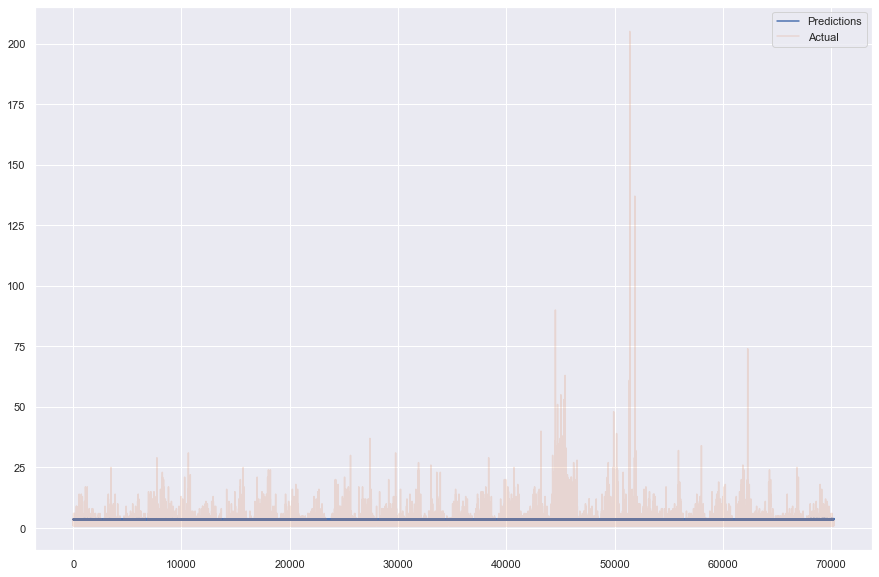

In [66]:
# I have to change change the scale of the actuals, or revert back the predictions to normal scale

plt.figure(figsize=(15, 10))
plt.plot(val_predictions, label='Predictions')
plt.plot(actuals, label='Actual', alpha=0.2)
plt.legend()
plt.show()

# Predict on the test data¶

In [70]:
pred,x=best_tft.predict(submission_dataloader,return_x=True)

IndexError: index 8 is out of bounds for dimension 1 with size 8

In [71]:
#df_test=df_submission.drop(['QTT'],axis=1)
#df_test['date_block_num']=34
#df_test['QTT']=0
decoder_data=df_test
encoder_data = df_train[lambda x: x.date_block_num > x.date_block_num.max() - max_encoder_length]
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
pred,x=best_tft.predict(df_test,return_x=True)

In [56]:
#df_test=df_test.drop(['QTT'],axis=1)
#df_test['date_block_num']=34
#df_test['item_cnt_month']=0
#decoder_data=df_test
#encoder_data = df_train[lambda x: x.date_block_num > x.date_block_num.max() - max_encoder_length]
#new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
pred,x=best_tft.predict(df_test,return_x=True)

In [72]:
pred.shape

torch.Size([23876, 1])

In [66]:
pred, x

(tensor([[0.3679],
         [0.3679],
         [0.3679],
         ...,
         [0.3679],
         [0.3679],
         [0.3679]]),
 {'encoder_cat': tensor([], size=(23876, 7, 0)),
  'encoder_cont': tensor([[[ 2.0000e+00,  1.0000e+00,  1.4000e+01,  ..., -1.3038e+02,
            -3.7037e-02, -1.3038e+02],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           ...,
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],
  
          [[ 2.0000e+00,  1.0000e+00,  1.4000e+01,  ..., -1.3038e+02,
            -3.7037e-02, -1.3038e+02],
           [ 0.0000e+0

### How to prepare it for kaggle 

In [36]:
df_submission_sample=df_submission.copy()

torch.Size([23876, 1])

In [73]:
df_submission_sample['QTT'] = pred
df_submission_sample.head()

ValueError: Length of values (23876) does not match length of index (69121)

In [ ]:
filename = os.path.join('./','submission_'+str(np.round(df_test_rmse,2))+'_local.csv')
print('Saving submission ',filename)
df_submission_sample[['ID','QTT']].to_csv(filename,index=None)

In [ ]:
df_submission_sample[['ID','QTT']].to_csv('submission.csv',index=None) # save to submission with kaggle

# Question 


- I don't think the date_num_block is okay, I believe I am taking out information 
- I need to rescale the predictions back to it's original value 
- How to compute the RMSE with scale and not scale value?? This doesn't make sense
- Need to plot the results 
- Don't understand the date_block_num from item count ot date count. How does it aggregate? It seems to aggregate weekly, although we are losing the totality of the combination of item. 

# Improvement

- Add new static covariates
- What are your know/unknow inputs? 
- Add day of the week, month, year